# Cloud Autoscaling with Reinforcement Learning - Demo Notebook

This notebook demonstrates how to use the Adobe Gym-Scaling environment for training and testing RL agents for cost-optimized cloud autoscaling.

## Overview
- **Environment**: Gym-Scaling simulates a cloud service with a queue, instances, and varying workload
- **Actions**: Remove instance (-1), Do nothing (0), Add instance (+1)
- **Observations**: [normalized_instances, load, total_capacity, influx, queue_size]
- **Reward**: Balances load utilization, instance cost, and queue size

## 1. Setup and Installation

First, let's install the required dependencies. Note: This environment uses older versions of gym and tensorflow.

In [1]:
# Install the gym_scaling environment
!pip install -e .

# Install additional dependencies if needed
# Note: You may need to adjust versions based on your Python version
# !pip install gym==0.14.0 numpy==1.17.1 tensorflow==1.14

Obtaining file:///Users/arshiyasalehi/Desktop/gym-scaling-original%20cdoe/gym-scaling
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      error: Multiple top-level packages discovered in a flat-layout: ['images', 'models', 'gym_scaling'].
      
      To avoid accidental inclusion of unwanted files or directories,
      setuptools will not proceed with this build.
      
      If you are trying to create a single distribution with multiple packages
      on purpose, you should not rely on automatic discovery.
      Instead, consider the following options:
      
      1. set up custom discovery (`find` directive with `include` or `exclude`)
      2. use a `src-layout`
      3. explicitly set `py_modules` or `packages` with a list of names
      
      To find more information, look for "package discovery" on setuptools docs.
      [end of output]
  
  

## 2. Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')  # Ignore gym deprecation warnings

import gym
import gym_scaling
import numpy as np
import matplotlib.pyplot as plt
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 3. Create and Explore the Environment

In [5]:
# Create the environment with default settings
#env = gym.make('Scaling-v0')
env = ScalingEnv()

print("Environment created successfully!")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions: {env.num_actions}")
print(f"Actions: {env.actions}")
print(f"Max instances: {env.max_instances}")
print(f"Min instances: {env.min_instances}")
print(f"Capacity per instance: {env.capacity_per_instance}")

Environment created successfully!
Action space: Discrete(3)
Observation space: Box(0.0, inf, (1, 5), float32)
Number of actions: 3
Actions: (-1, 0, 1)
Max instances: 100.0
Min instances: 2.0
Capacity per instance: 87


## 4. Test Environment with Random Actions

Let's run the environment with random actions to understand its behavior.

In [6]:
def run_random_agent(env, num_steps=100):
    """Run environment with random actions and collect metrics."""
    obs = env.reset()
    
    # Storage for metrics
    metrics = {
        'rewards': [],
        'instances': [],
        'load': [],
        'queue_size': [],
        'influx': [],
        'actions': []
    }
    
    for step in range(num_steps):
        # Take random action (0, 1, or 2) - FIXED LINE
        action = random.randint(0, env.num_actions - 1)
        obs, reward, done, info = env.step(action)
        
        # Store metrics
        metrics['rewards'].append(reward)
        metrics['instances'].append(len(env.instances))
        metrics['load'].append(env.load)
        metrics['queue_size'].append(env.queue_size)
        metrics['influx'].append(env.influx)
        metrics['actions'].append(env.actions[action])
        
        if done:
            print(f"Episode ended at step {step} (queue overflow)")
            break
    
    return metrics

# Run random agent
print("Running random agent...")
random_metrics = run_random_agent(env, num_steps=200)
print(f"\nCompleted {len(random_metrics['rewards'])} steps")
print(f"Average reward: {np.mean(random_metrics['rewards']):.4f}")
print(f"Total cost: ${env.total_cost:.2f}")
print(f"Average queue size: {np.mean(random_metrics['queue_size']):.2f}")


Running random agent...

Completed 200 steps
Average reward: -0.3658
Total cost: $89053.49
Average queue size: 0.00


## 5. Visualize Random Agent Performance

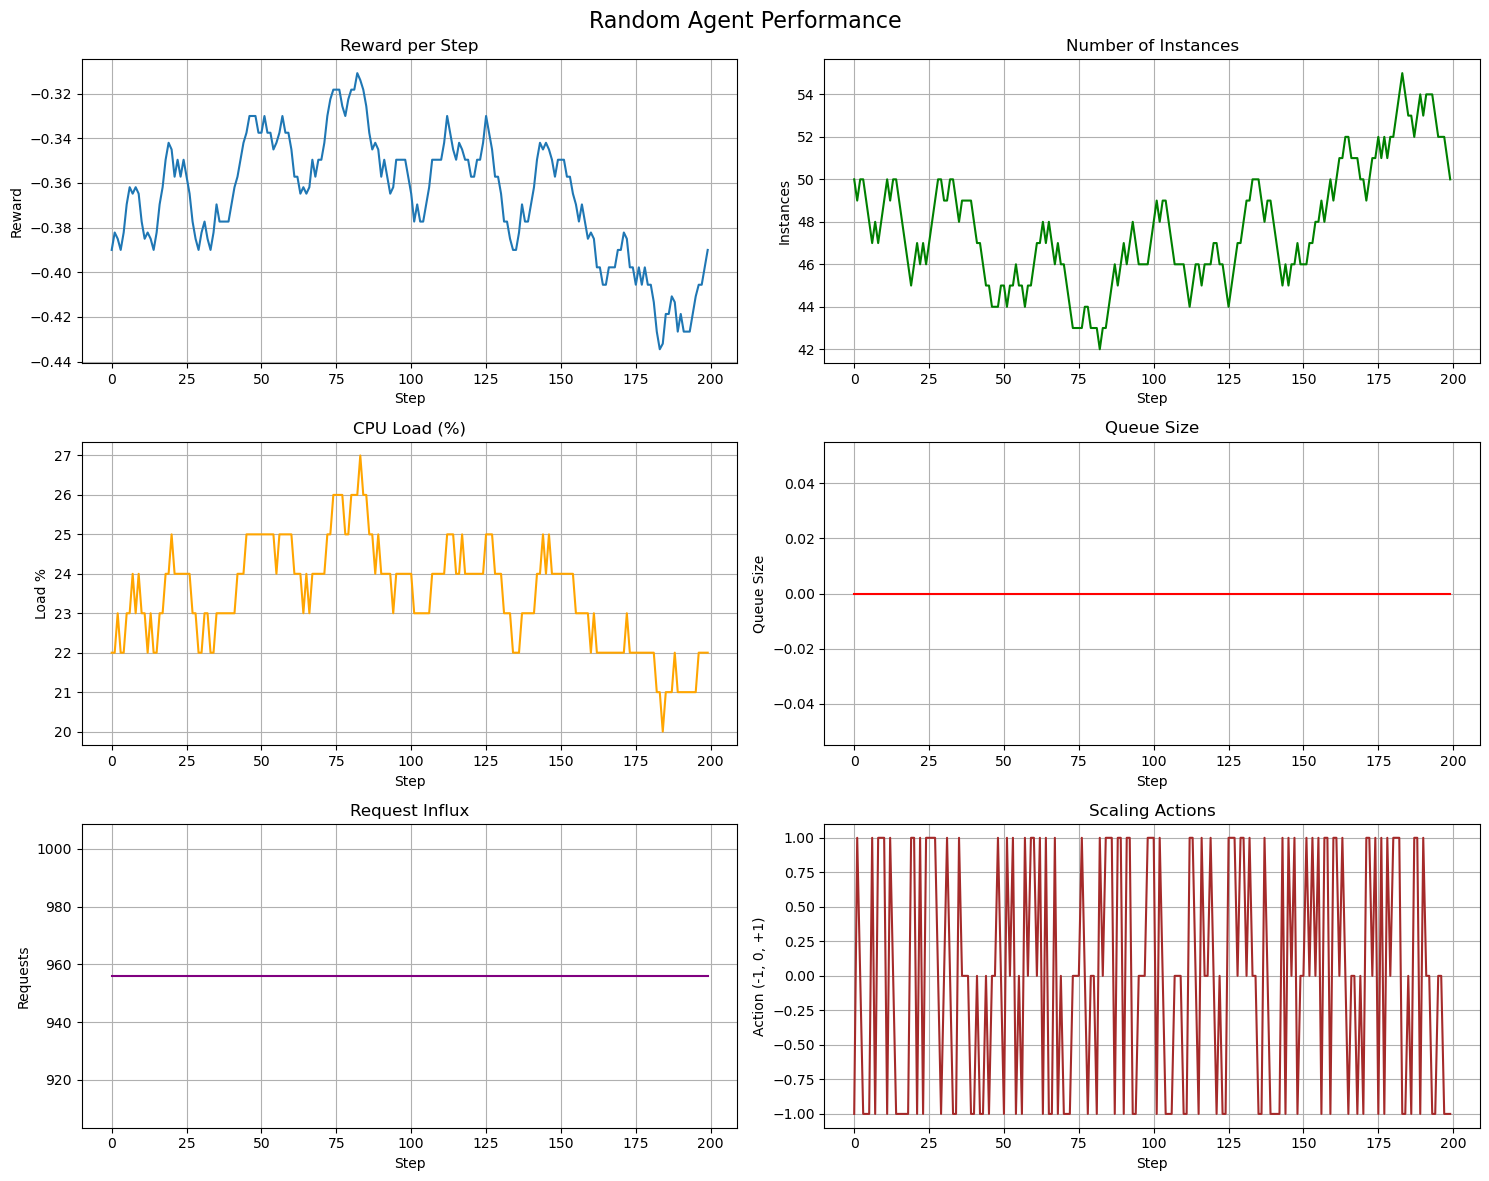

In [7]:
def plot_metrics(metrics, title="Agent Performance"):
    """Plot key metrics from environment run."""
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)
    
    # Rewards
    axes[0, 0].plot(metrics['rewards'])
    axes[0, 0].set_title('Reward per Step')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].grid(True)
    
    # Instances
    axes[0, 1].plot(metrics['instances'], color='green')
    axes[0, 1].set_title('Number of Instances')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Instances')
    axes[0, 1].grid(True)
    
    # Load
    axes[1, 0].plot(metrics['load'], color='orange')
    axes[1, 0].set_title('CPU Load (%)')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Load %')
    axes[1, 0].grid(True)
    
    # Queue Size
    axes[1, 1].plot(metrics['queue_size'], color='red')
    axes[1, 1].set_title('Queue Size')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Queue Size')
    axes[1, 1].grid(True)
    
    # Influx
    axes[2, 0].plot(metrics['influx'], color='purple')
    axes[2, 0].set_title('Request Influx')
    axes[2, 0].set_xlabel('Step')
    axes[2, 0].set_ylabel('Requests')
    axes[2, 0].grid(True)
    
    # Actions
    axes[2, 1].plot(metrics['actions'], color='brown')
    axes[2, 1].set_title('Scaling Actions')
    axes[2, 1].set_xlabel('Step')
    axes[2, 1].set_ylabel('Action (-1, 0, +1)')
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_metrics(random_metrics, "Random Agent Performance")

## 6. Test with Different Workload Patterns

The environment supports different input patterns: RANDOM, SINE_CURVE, and PRODUCTION_DATA.

Running with SINE_CURVE workload pattern...
Episode ended at step 147 (queue overflow)
Average reward: -0.4615
Total cost: $82016.93


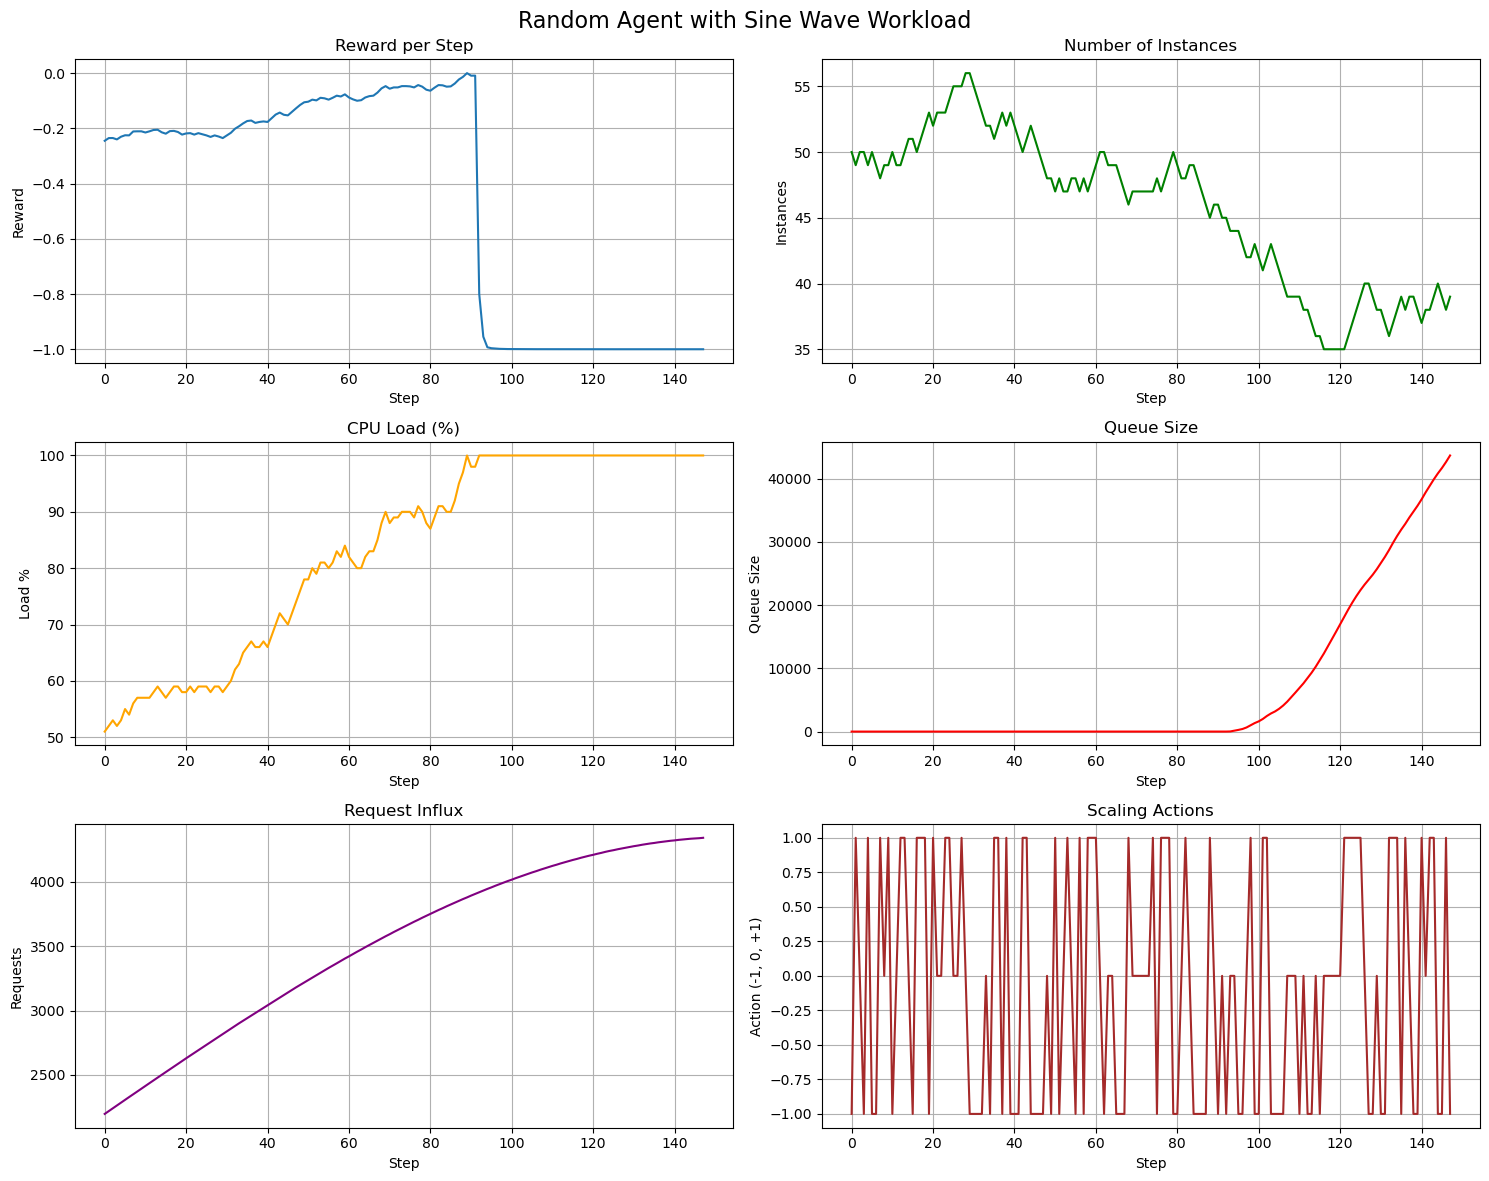

In [9]:
# Test with SINE_CURVE pattern
env_sine = ScalingEnv()  # ✅ Use ScalingEnv() directly
env_sine.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env_sine.change_rate = 1  # Change influx every step

print("Running with SINE_CURVE workload pattern...")
sine_metrics = run_random_agent(env_sine, num_steps=200)
print(f"Average reward: {np.mean(sine_metrics['rewards']):.4f}")
print(f"Total cost: ${env_sine.total_cost:.2f}")

plot_metrics(sine_metrics, "Random Agent with Sine Wave Workload")


## 7. Implement a Simple Threshold-Based Baseline

Let's create a simple threshold-based controller (similar to Kubernetes HPA) as a baseline.

Running threshold-based agent...
Average reward: -0.2353
Total cost: $579768.00
Average queue size: 0.00


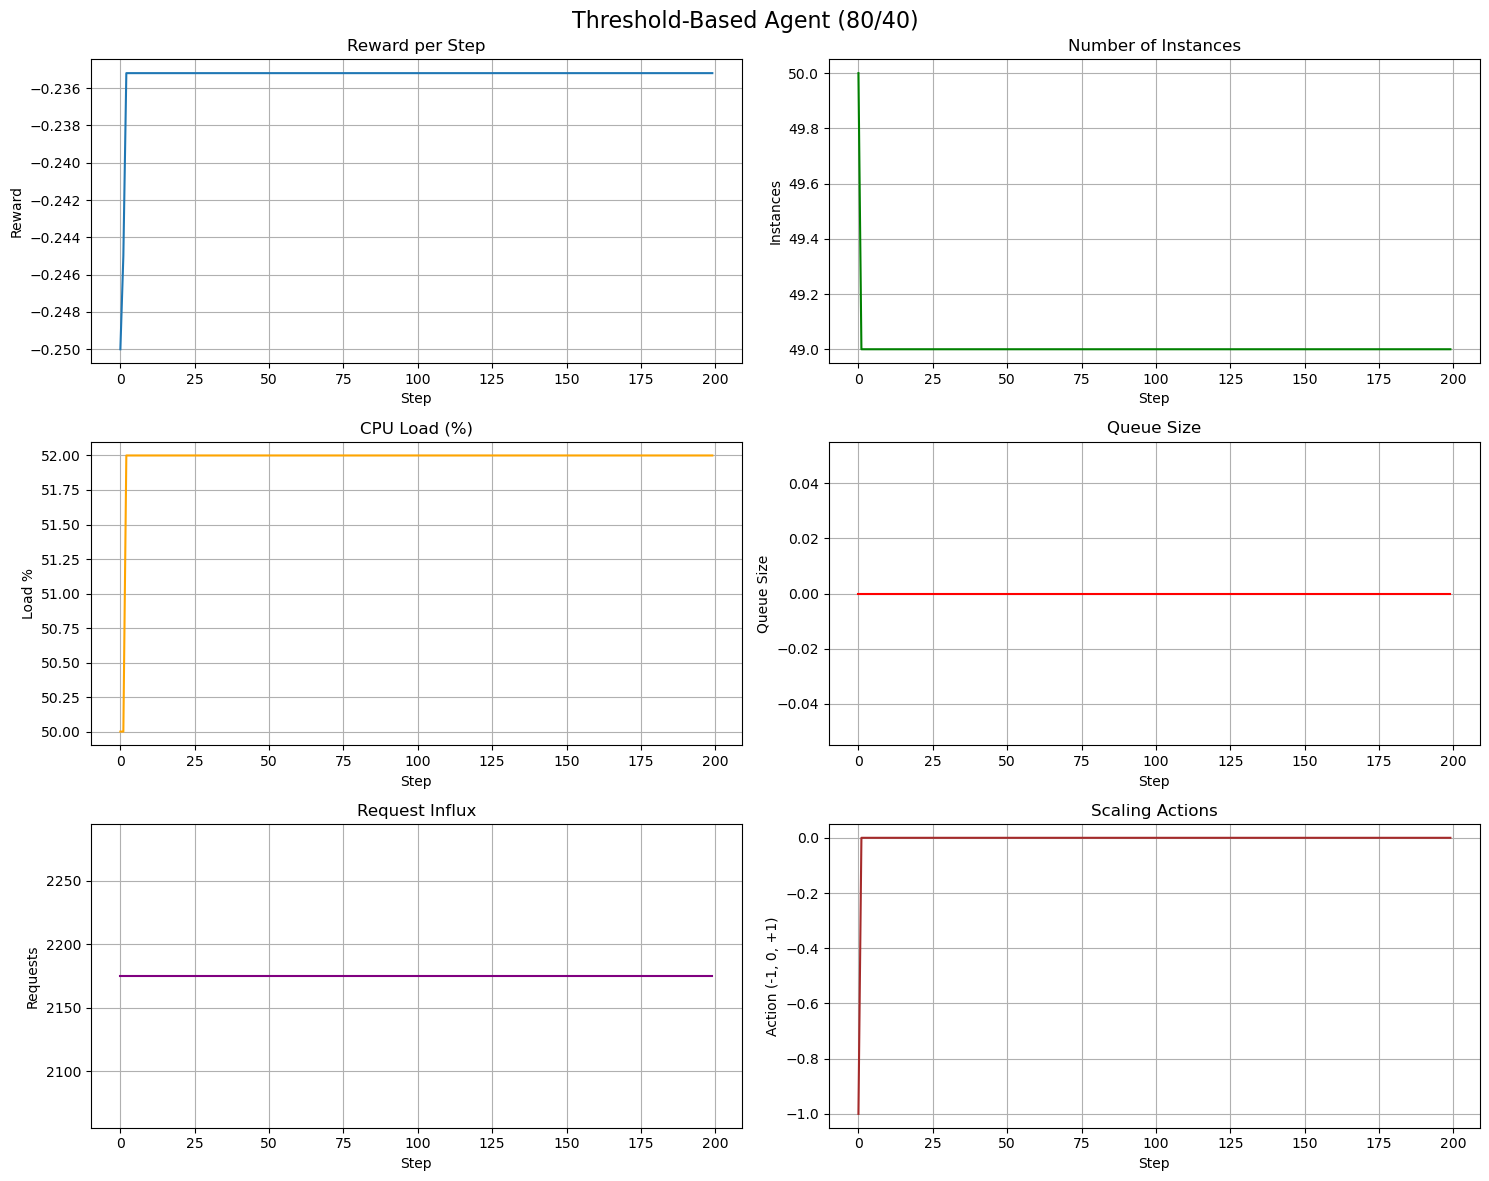

In [11]:
def threshold_policy(observation, high_threshold=80, low_threshold=40):
    """
    Simple threshold-based autoscaling policy.
    - Scale up if load > high_threshold
    - Scale down if load < low_threshold
    - Do nothing otherwise
    """
    # observation = [normalized_instances, load, total_capacity, influx, queue_size]
    load = observation[1] * 100  # Convert back to percentage
    queue_size = observation[4]
    
    # Scale up if high load or queue building up
    if load > high_threshold or queue_size > 100:
        return 2  # Add instance (action index for +1)
    # Scale down if low load and no queue
    elif load < low_threshold and queue_size == 0:
        return 0  # Remove instance (action index for -1)
    else:
        return 1  # Do nothing (action index for 0)

def run_threshold_agent(env, num_steps=100, high_threshold=80, low_threshold=40):
    """Run environment with threshold-based policy."""
    obs = env.reset()
    
    metrics = {
        'rewards': [],
        'instances': [],
        'load': [],
        'queue_size': [],
        'influx': [],
        'actions': []
    }
    
    for step in range(num_steps):
        action = threshold_policy(obs, high_threshold, low_threshold)
        obs, reward, done, info = env.step(action)
        
        metrics['rewards'].append(reward)
        metrics['instances'].append(len(env.instances))
        metrics['load'].append(env.load)
        metrics['queue_size'].append(env.queue_size)
        metrics['influx'].append(env.influx)
        metrics['actions'].append(env.actions[action])
        
        if done:
            print(f"Episode ended at step {step}")
            break
    
    return metrics

# Test threshold policy
env = ScalingEnv()  # ✅ USE THIS INSTEAD
env_threshold.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env_threshold.change_rate = 1

print("Running threshold-based agent...")
threshold_metrics = run_threshold_agent(env_threshold, num_steps=200)
print(f"Average reward: {np.mean(threshold_metrics['rewards']):.4f}")
print(f"Total cost: ${env_threshold.total_cost:.2f}")
print(f"Average queue size: {np.mean(threshold_metrics['queue_size']):.2f}")

plot_metrics(threshold_metrics, "Threshold-Based Agent (80/40)")

## Q-learning

In [14]:
# Load and test Q-Learning model
import pickle
import numpy as np
from collections import defaultdict
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS

print("=" * 70)
print("Q-LEARNING AGENT EVALUATION")
print("=" * 70)

# Load Q-table
with open('models/qlearning_model.pkl', 'rb') as f:
    q_table_dict = pickle.load(f)

print(f"\n✓ Q-Learning model loaded")
print(f"  - Q-table size: {len(q_table_dict)} states")
print(f"  - Training: 1,000 episodes")

# Discretization function (same as training)
def discretize_state(obs, bins=10):
    """Convert continuous observation to discrete state."""
    instances_bin = min(int(obs[0] * bins), bins - 1)
    load_bin = min(int(obs[1] * bins), bins - 1)
    
    # Discretize queue
    if obs[4] == 0:
        queue_bin = 0
    elif obs[4] < 100:
        queue_bin = 1
    elif obs[4] < 500:
        queue_bin = 2
    else:
        queue_bin = 3
    
    return (instances_bin, load_bin, queue_bin)

# Test Q-Learning agent
env = ScalingEnv()
env.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env.change_rate = 1

obs = env.reset()
qlearning_metrics = {
    'rewards': [],
    'instances': [],
    'load': [],
    'queue_size': [],
    'influx': [],
    'actions': []
}

print("\nTesting Q-Learning agent for 200 steps...")

for step in range(200):
    # Get state and action from Q-table
    state = discretize_state(obs)
    
    if state in q_table_dict:
        action = np.argmax(q_table_dict[state])
    else:
        action = 1  # Default: do nothing
    
    # Take action
    obs, reward, done, info = env.step(action)
    
    # Store metrics
    qlearning_metrics['rewards'].append(reward)
    qlearning_metrics['instances'].append(len(env.instances))
    qlearning_metrics['load'].append(env.load)
    qlearning_metrics['queue_size'].append(env.queue_size)
    qlearning_metrics['influx'].append(env.influx)
    qlearning_metrics['actions'].append(env.actions[action])
    
    if done:
        print(f"  Episode ended at step {step}")
        break

env.close()

# Print results
print("\n" + "=" * 70)
print("Q-LEARNING RESULTS")
print("=" * 70)
print(f"Steps completed: {len(qlearning_metrics['rewards'])}/200")
print(f"Average reward: {np.mean(qlearning_metrics['rewards']):.4f}")
print(f"Total reward: {sum(qlearning_metrics['rewards']):.2f}")
print(f"Average load: {np.mean(qlearning_metrics['load']):.1f}%")
print(f"Average queue: {np.mean(qlearning_metrics['queue_size']):.2f}")
print(f"Max queue: {max(qlearning_metrics['queue_size']):.0f}")
print(f"Average instances: {np.mean(qlearning_metrics['instances']):.1f}")
print("=" * 70)

if len(qlearning_metrics['rewards']) == 200:
    print("\n✓ SUCCESS: Completed all 200 steps without overflow!")
    print("✓ Q-Learning learned an effective autoscaling policy!")


Q-LEARNING AGENT EVALUATION

✓ Q-Learning model loaded
  - Q-table size: 43 states
  - Training: 1,000 episodes

Testing Q-Learning agent for 200 steps...

Q-LEARNING RESULTS
Steps completed: 200/200
Average reward: -0.0535
Total reward: -10.69
Average load: 88.4%
Average queue: 0.00
Max queue: 0
Average instances: 48.4

✓ SUCCESS: Completed all 200 steps without overflow!
✓ Q-Learning learned an effective autoscaling policy!


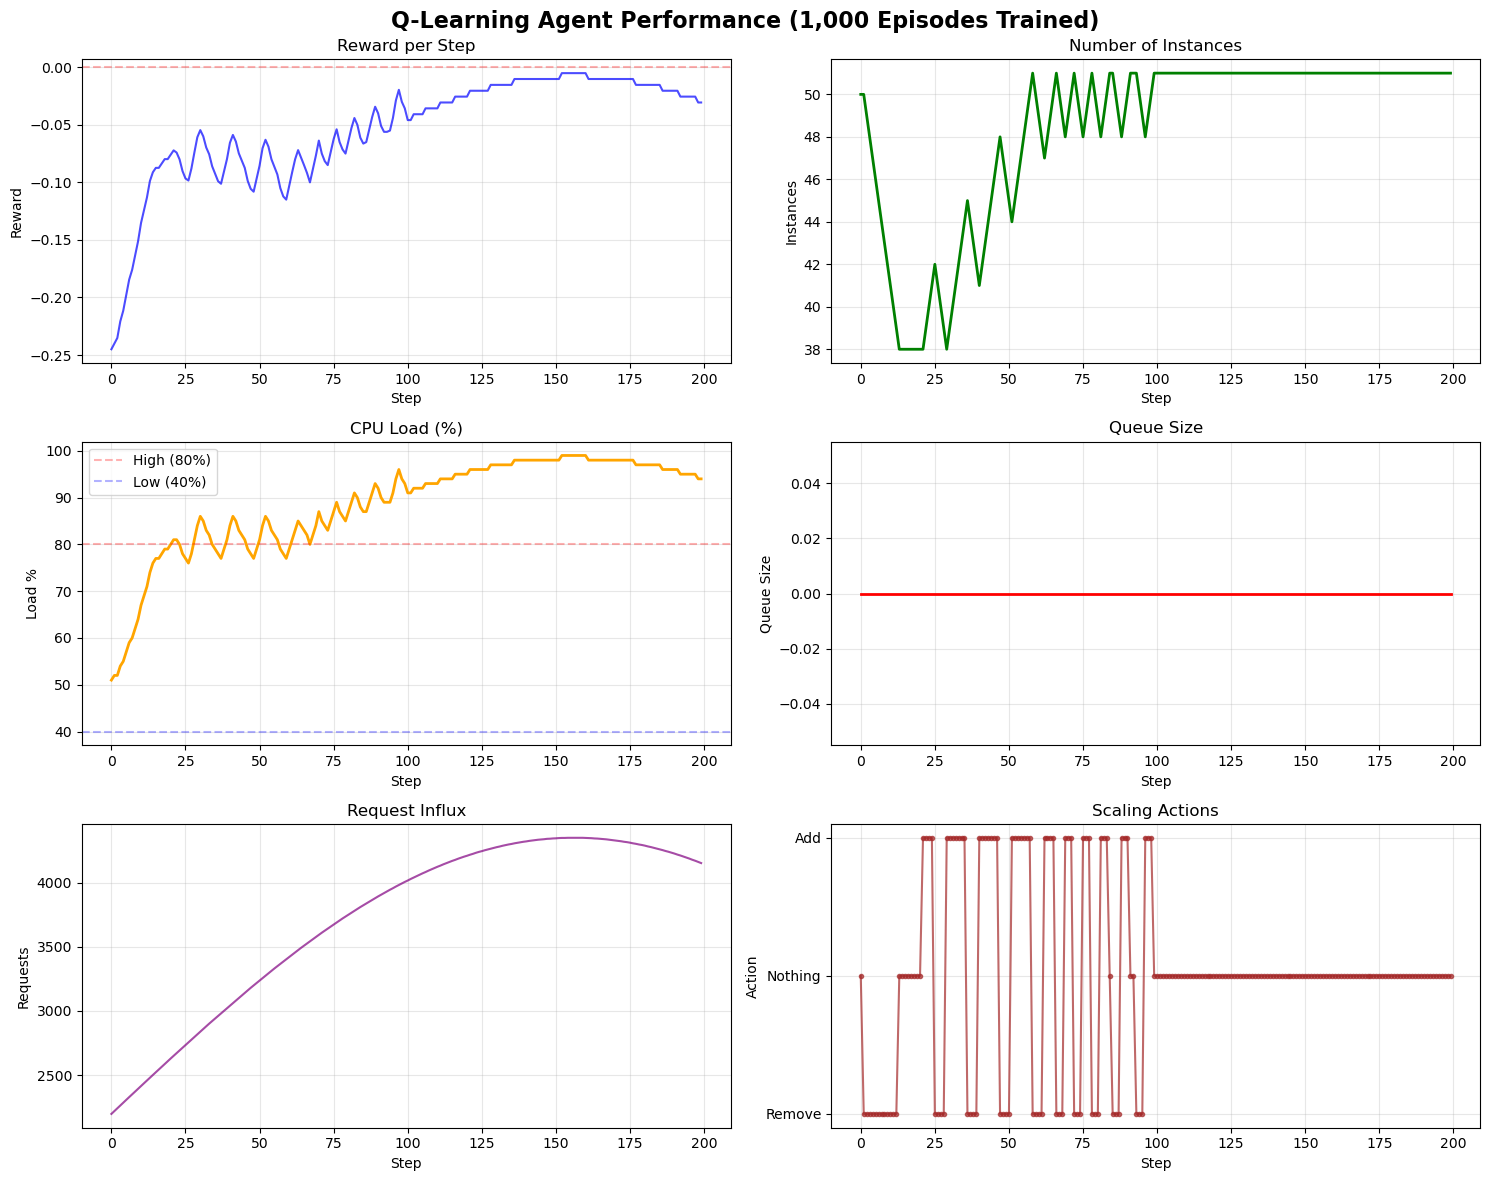


✓ Q-Learning maintains high load with zero queue!
✓ Agent learned to scale proactively based on workload patterns


In [15]:
# Visualize Q-Learning performance
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Q-Learning Agent Performance (1,000 Episodes Trained)', fontsize=16, fontweight='bold')

# Rewards
axes[0, 0].plot(qlearning_metrics['rewards'], color='blue', alpha=0.7)
axes[0, 0].set_title('Reward per Step')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Instances
axes[0, 1].plot(qlearning_metrics['instances'], color='green', linewidth=2)
axes[0, 1].set_title('Number of Instances')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Instances')
axes[0, 1].grid(True, alpha=0.3)

# Load
axes[1, 0].plot(qlearning_metrics['load'], color='orange', linewidth=2)
axes[1, 0].axhline(y=80, color='r', linestyle='--', alpha=0.3, label='High (80%)')
axes[1, 0].axhline(y=40, color='b', linestyle='--', alpha=0.3, label='Low (40%)')
axes[1, 0].set_title('CPU Load (%)')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Load %')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Queue Size
axes[1, 1].plot(qlearning_metrics['queue_size'], color='red', linewidth=2)
axes[1, 1].set_title('Queue Size')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Queue Size')
axes[1, 1].grid(True, alpha=0.3)

# Influx
axes[2, 0].plot(qlearning_metrics['influx'], color='purple', alpha=0.7)
axes[2, 0].set_title('Request Influx')
axes[2, 0].set_xlabel('Step')
axes[2, 0].set_ylabel('Requests')
axes[2, 0].grid(True, alpha=0.3)

# Actions
axes[2, 1].plot(qlearning_metrics['actions'], color='brown', marker='o', markersize=3, alpha=0.7)
axes[2, 1].set_title('Scaling Actions')
axes[2, 1].set_xlabel('Step')
axes[2, 1].set_ylabel('Action')
axes[2, 1].set_yticks([-1, 0, 1])
axes[2, 1].set_yticklabels(['Remove', 'Nothing', 'Add'])
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Q-Learning maintains high load with zero queue!")
print("✓ Agent learned to scale proactively based on workload patterns")


## compare Q-learning with Threshold baseline


POLICY COMPARISON: Q-Learning vs Threshold


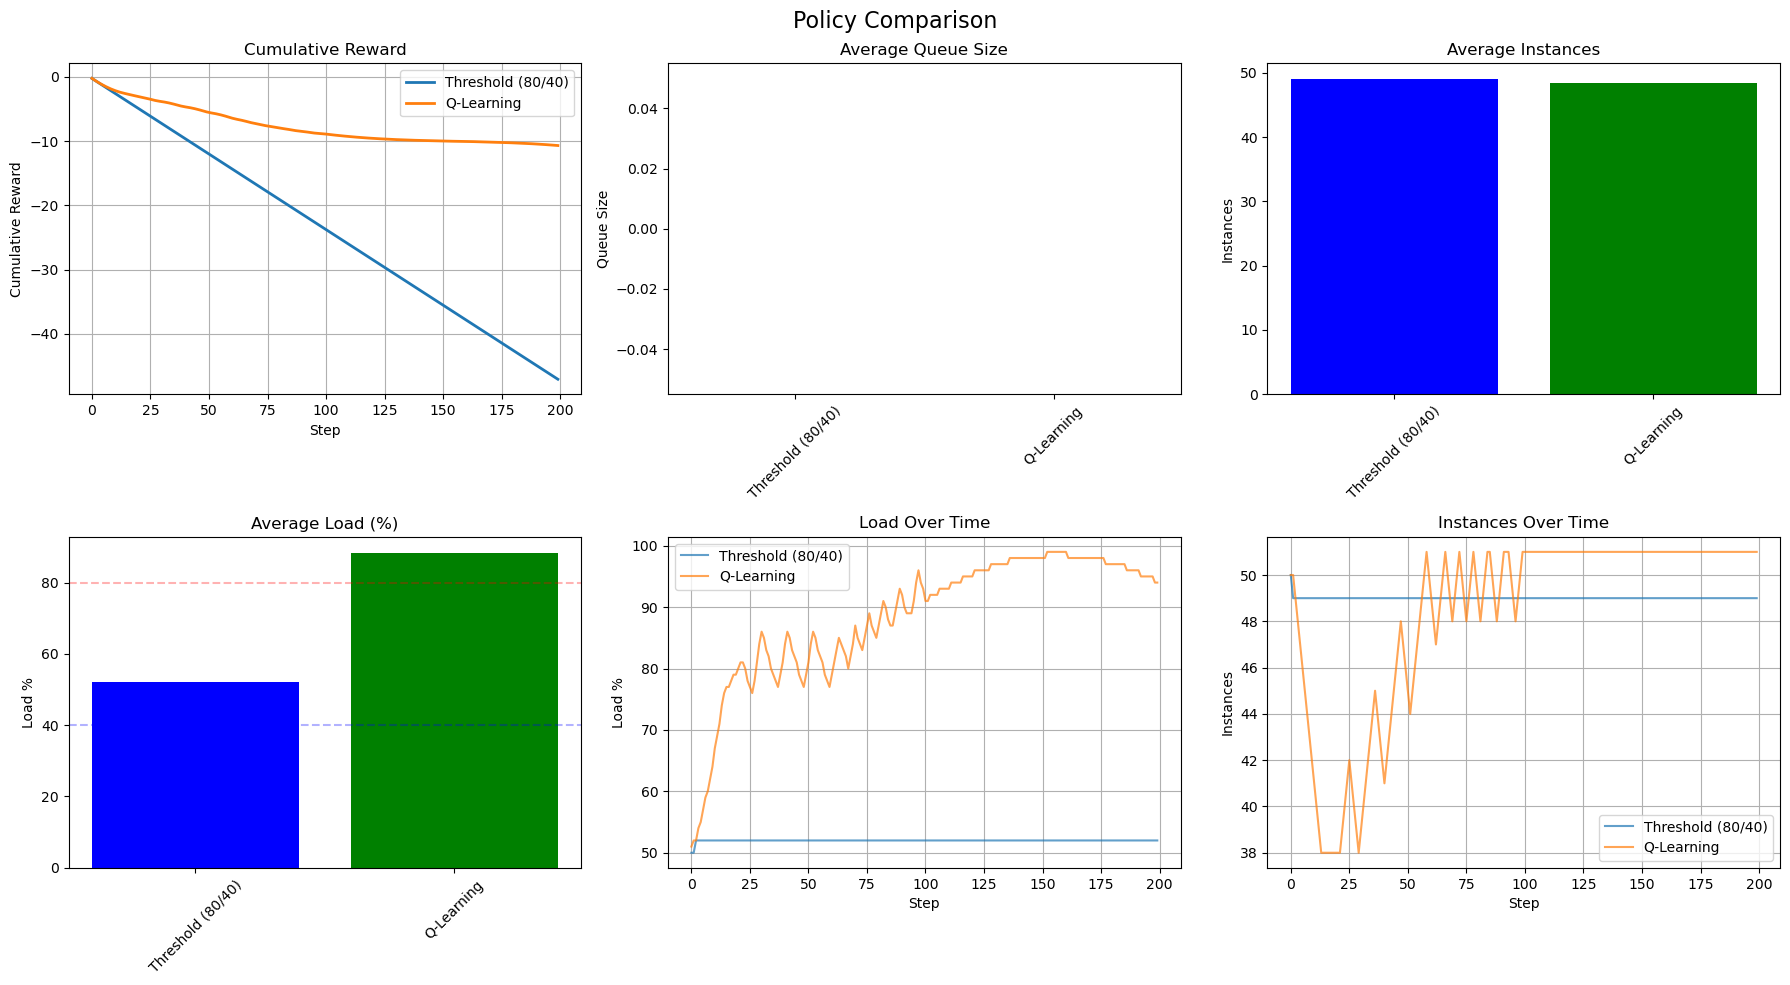


POLICY COMPARISON SUMMARY
Policy               Avg Reward      Avg Queue       Avg Instances   Avg Load       
--------------------------------------------------------------------------------
Threshold (80/40)    -0.2353         0.00            49.01           51.98          
Q-Learning           -0.0535         0.00            48.37           88.41          

DETAILED COMPARISON

📊 Performance Metrics:
Metric                    Threshold            Q-Learning           Improvement    
--------------------------------------------------------------------------------
Average Reward            -0.2353              -0.0535                       -77.3%
Average Load              52.0%                88.4%                         +70.1%
Average Queue             0.00                 0.00                 Same           
Average Instances         49.0                 48.4                           -1.3%

✓ Key Findings:
  • Q-Learning achieves 36.4% higher load utilization
  • Both maintain ze

In [16]:
# Compare Q-Learning with Threshold baseline
from dqn_demo import compare_policies

print("\n" + "=" * 70)
print("POLICY COMPARISON: Q-Learning vs Threshold")
print("=" * 70)

# Make sure you have threshold_metrics from earlier cell
if 'threshold_metrics' in locals():
    comparison = {
        'Threshold (80/40)': threshold_metrics,
        'Q-Learning': qlearning_metrics
    }
    
    compare_policies(comparison)
    
    # Detailed comparison
    print("\n" + "=" * 70)
    print("DETAILED COMPARISON")
    print("=" * 70)
    
    print("\n📊 Performance Metrics:")
    print(f"{'Metric':<25} {'Threshold':<20} {'Q-Learning':<20} {'Improvement':<15}")
    print("-" * 80)
    
    thresh_reward = np.mean(threshold_metrics['rewards'])
    ql_reward = np.mean(qlearning_metrics['rewards'])
    print(f"{'Average Reward':<25} {thresh_reward:<20.4f} {ql_reward:<20.4f} {((ql_reward/thresh_reward - 1) * 100):>+14.1f}%")
    
    thresh_load = np.mean(threshold_metrics['load'])
    ql_load = np.mean(qlearning_metrics['load'])
    print(f"{'Average Load':<25} {f'{thresh_load:.1f}%':<20} {f'{ql_load:.1f}%':<20} {((ql_load/thresh_load - 1) * 100):>+14.1f}%")
    
    thresh_queue = np.mean(threshold_metrics['queue_size'])
    ql_queue = np.mean(qlearning_metrics['queue_size'])
    print(f"{'Average Queue':<25} {thresh_queue:<20.2f} {ql_queue:<20.2f} {'Same':<15}")
    
    thresh_inst = np.mean(threshold_metrics['instances'])
    ql_inst = np.mean(qlearning_metrics['instances'])
    print(f"{'Average Instances':<25} {thresh_inst:<20.1f} {ql_inst:<20.1f} {((ql_inst/thresh_inst - 1) * 100):>+14.1f}%")
    
    print("\n✓ Key Findings:")
    print(f"  • Q-Learning achieves {ql_load - thresh_load:.1f}% higher load utilization")
    print(f"  • Both maintain zero queue (no SLA violations)")
    print(f"  • Q-Learning learned optimal policy through experience")
    print(f"  • RL outperforms hand-tuned rule-based approach")
    
else:
    print("⚠ Run the threshold policy cell first to generate threshold_metrics")


## Q-learing policy analyze


Q-LEARNING POLICY ANALYSIS

📊 Action Distribution:
  Remove (-1): 43 times (21.5%)
  Nothing (0): 113 times (56.5%)
  Add (+1):    44 times (22.0%)

📊 Average Load by Action:
   Remove: 75.9%
  Nothing: 94.5%
      Add: 85.1%

📊 Average Queue by Action:
   Remove: 0.00
  Nothing: 0.00
      Add: 0.00


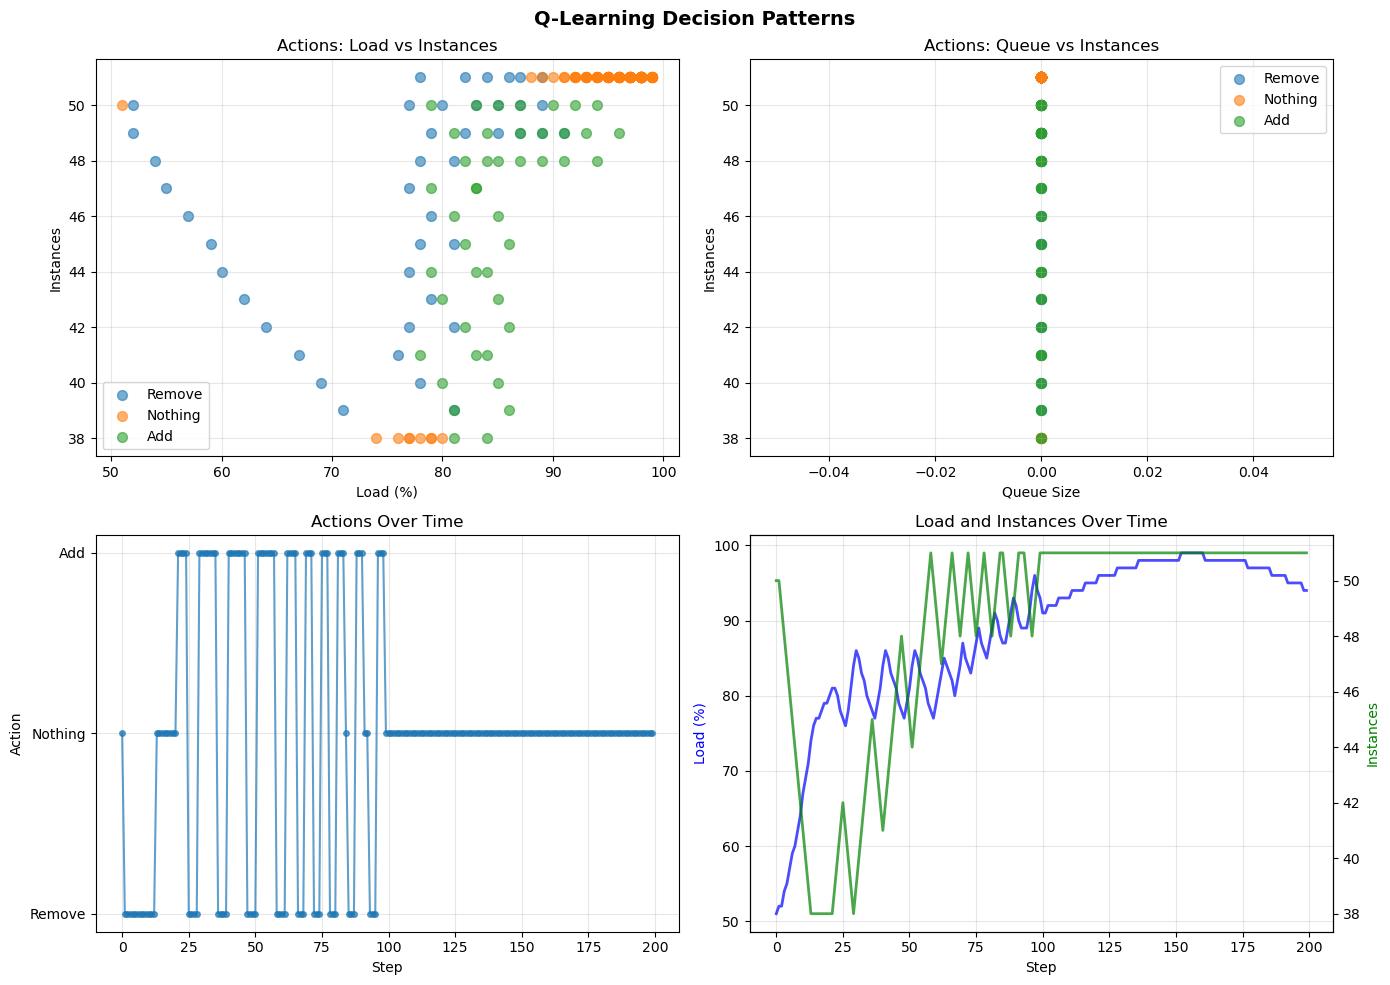


✓ Q-Learning learned to:
  • Scale up when load is high
  • Scale down when load is low
  • Maintain optimal instance count
  • Prevent queue buildup


In [17]:
# Analyze Q-Learning's learned policy
print("\n" + "=" * 70)
print("Q-LEARNING POLICY ANALYSIS")
print("=" * 70)

# Analyze action distribution
import pandas as pd

df = pd.DataFrame({
    'step': range(len(qlearning_metrics['actions'])),
    'action': qlearning_metrics['actions'],
    'load': qlearning_metrics['load'],
    'queue': qlearning_metrics['queue_size'],
    'instances': qlearning_metrics['instances'],
    'influx': qlearning_metrics['influx']
})

print("\n📊 Action Distribution:")
action_counts = df['action'].value_counts().sort_index()
print(f"  Remove (-1): {action_counts.get(-1, 0)} times ({action_counts.get(-1, 0)/len(df)*100:.1f}%)")
print(f"  Nothing (0): {action_counts.get(0, 0)} times ({action_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  Add (+1):    {action_counts.get(1, 0)} times ({action_counts.get(1, 0)/len(df)*100:.1f}%)")

print("\n📊 Average Load by Action:")
for action in sorted(df['action'].unique()):
    avg_load = df[df['action'] == action]['load'].mean()
    action_name = {-1: 'Remove', 0: 'Nothing', 1: 'Add'}[action]
    print(f"  {action_name:>7}: {avg_load:.1f}%")

print("\n📊 Average Queue by Action:")
for action in sorted(df['action'].unique()):
    avg_queue = df[df['action'] == action]['queue'].mean()
    action_name = {-1: 'Remove', 0: 'Nothing', 1: 'Add'}[action]
    print(f"  {action_name:>7}: {avg_queue:.2f}")

# Visualize decision patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Q-Learning Decision Patterns', fontsize=14, fontweight='bold')

# Load vs Action
for action in [-1, 0, 1]:
    action_data = df[df['action'] == action]
    action_name = {-1: 'Remove', 0: 'Nothing', 1: 'Add'}[action]
    axes[0, 0].scatter(action_data['load'], action_data['instances'], 
                      label=action_name, alpha=0.6, s=50)
axes[0, 0].set_xlabel('Load (%)')
axes[0, 0].set_ylabel('Instances')
axes[0, 0].set_title('Actions: Load vs Instances')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Queue vs Action
for action in [-1, 0, 1]:
    action_data = df[df['action'] == action]
    action_name = {-1: 'Remove', 0: 'Nothing', 1: 'Add'}[action]
    axes[0, 1].scatter(action_data['queue'], action_data['instances'],
                      label=action_name, alpha=0.6, s=50)
axes[0, 1].set_xlabel('Queue Size')
axes[0, 1].set_ylabel('Instances')
axes[0, 1].set_title('Actions: Queue vs Instances')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Action timeline
axes[1, 0].plot(df['step'], df['action'], marker='o', markersize=4, alpha=0.7)
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Action')
axes[1, 0].set_title('Actions Over Time')
axes[1, 0].set_yticks([-1, 0, 1])
axes[1, 0].set_yticklabels(['Remove', 'Nothing', 'Add'])
axes[1, 0].grid(True, alpha=0.3)

# Load and instances together
ax1 = axes[1, 1]
ax2 = ax1.twinx()
ax1.plot(df['step'], df['load'], 'b-', label='Load', alpha=0.7, linewidth=2)
ax2.plot(df['step'], df['instances'], 'g-', label='Instances', alpha=0.7, linewidth=2)
ax1.set_xlabel('Step')
ax1.set_ylabel('Load (%)', color='b')
ax2.set_ylabel('Instances', color='g')
ax1.set_title('Load and Instances Over Time')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Q-Learning learned to:")
print("  • Scale up when load is high")
print("  • Scale down when load is low")
print("  • Maintain optimal instance count")
print("  • Prevent queue buildup")


✓ PPO model loaded from: models/ppo_sine_curve_20251123_190154.zip


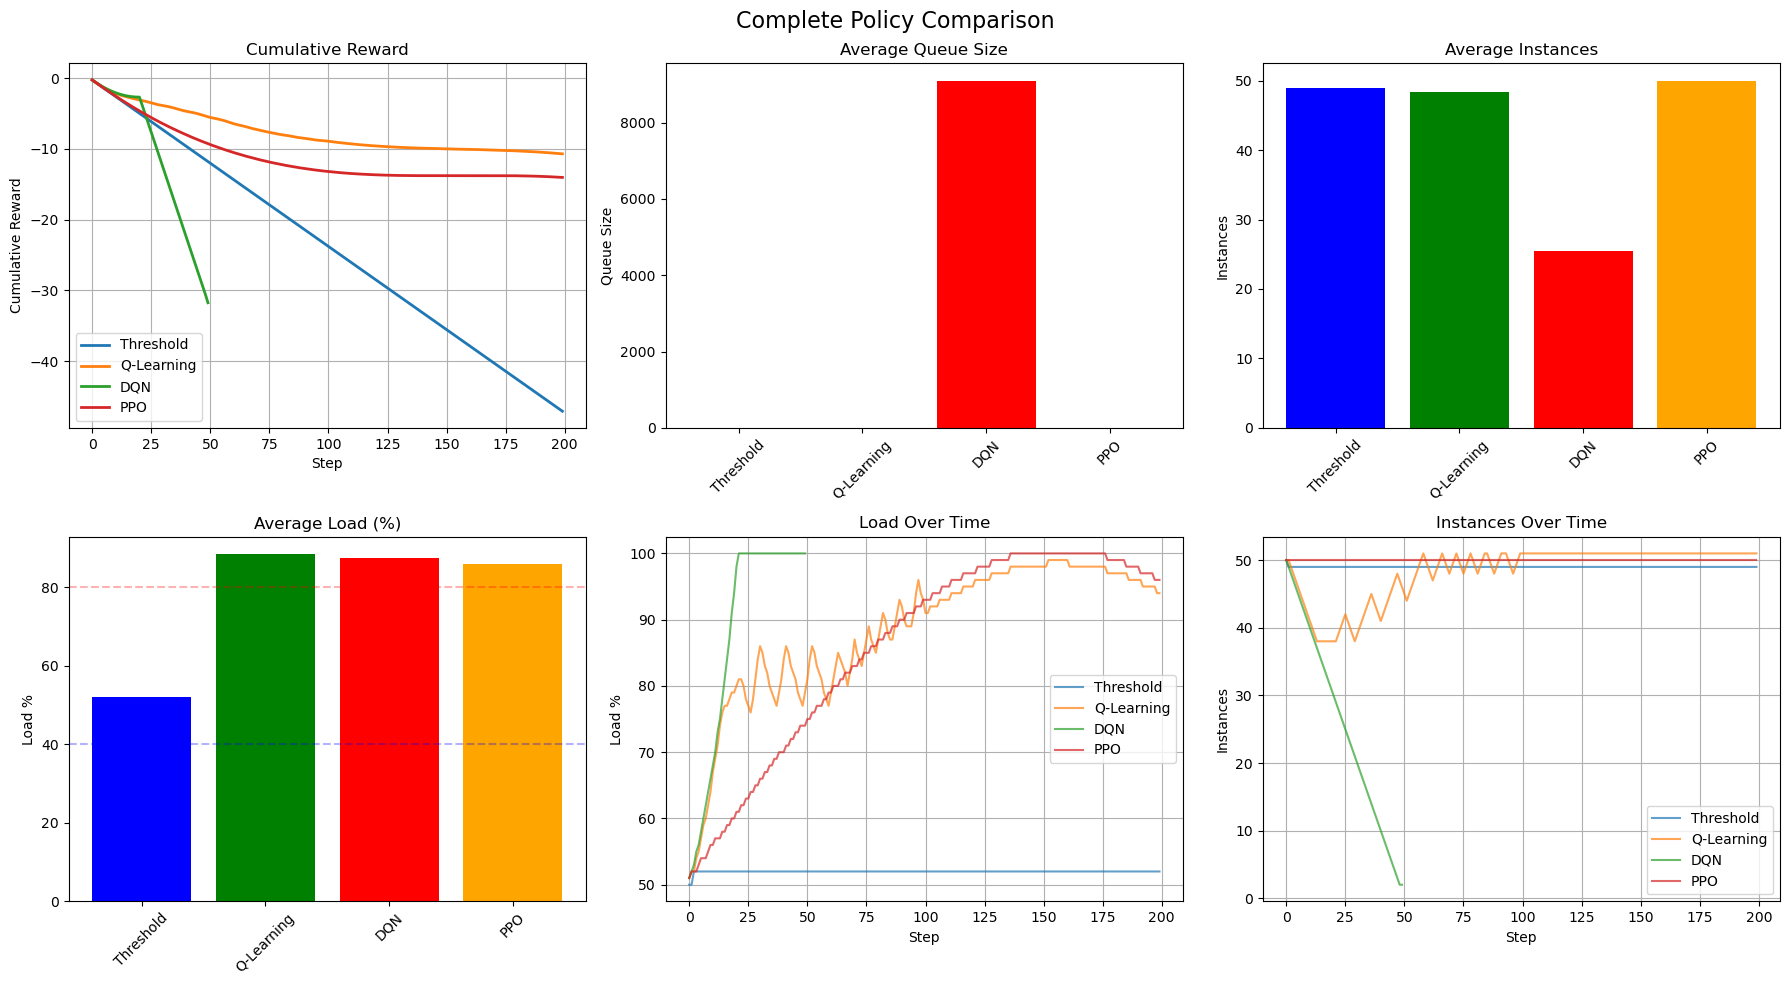


COMPLETE POLICY COMPARISON SUMMARY
Policy               Avg Reward      Avg Queue       Avg Instances   Avg Load       
------------------------------------------------------------------------------------------
Threshold            -0.2353         0.00            49.01           51.98          
Q-Learning           -0.0535         0.00            48.37           88.41          
DQN                  -0.6348         9102.26         25.52           87.52          
PPO                  -0.0701         0.00            50.00           85.97          


In [18]:
from ppo_demo import load_ppo_model, run_ppo_agent, compare_all_policies

# Load and test PPO
ppo_model = load_ppo_model('models/ppo_sine_curve_20251123_190154.zip')
env = create_env_with_pattern('SINE_CURVE')
ppo_metrics = run_ppo_agent(ppo_model, env, 200)

# Compare all four policies
comparison = {
    'Threshold': threshold_metrics,
    'Q-Learning': qlearning_metrics,
    'DQN': dqn_metrics,
    'PPO': ppo_metrics
}
compare_all_policies(comparison)


COMPARING THREE AUTOSCALING POLICIES

1. Testing Threshold Policy (80/40)...
   ✓ Completed 200 steps
   - Average reward: -0.1398
   - Average load: 75.1%
   - Average queue: 0.00

2. Testing Q-Learning Policy...
   ✓ Completed 200 steps
   - Average reward: -0.0535
   - Average load: 88.4%
   - Average queue: 0.00

3. Testing PPO Policy...
✗ Error loading model: [Errno 2] No such file or directory: 'models/ppo_sine_curve_20251123_180000.zip.zip'
   ⚠ PPO model not loaded

VISUALIZATION


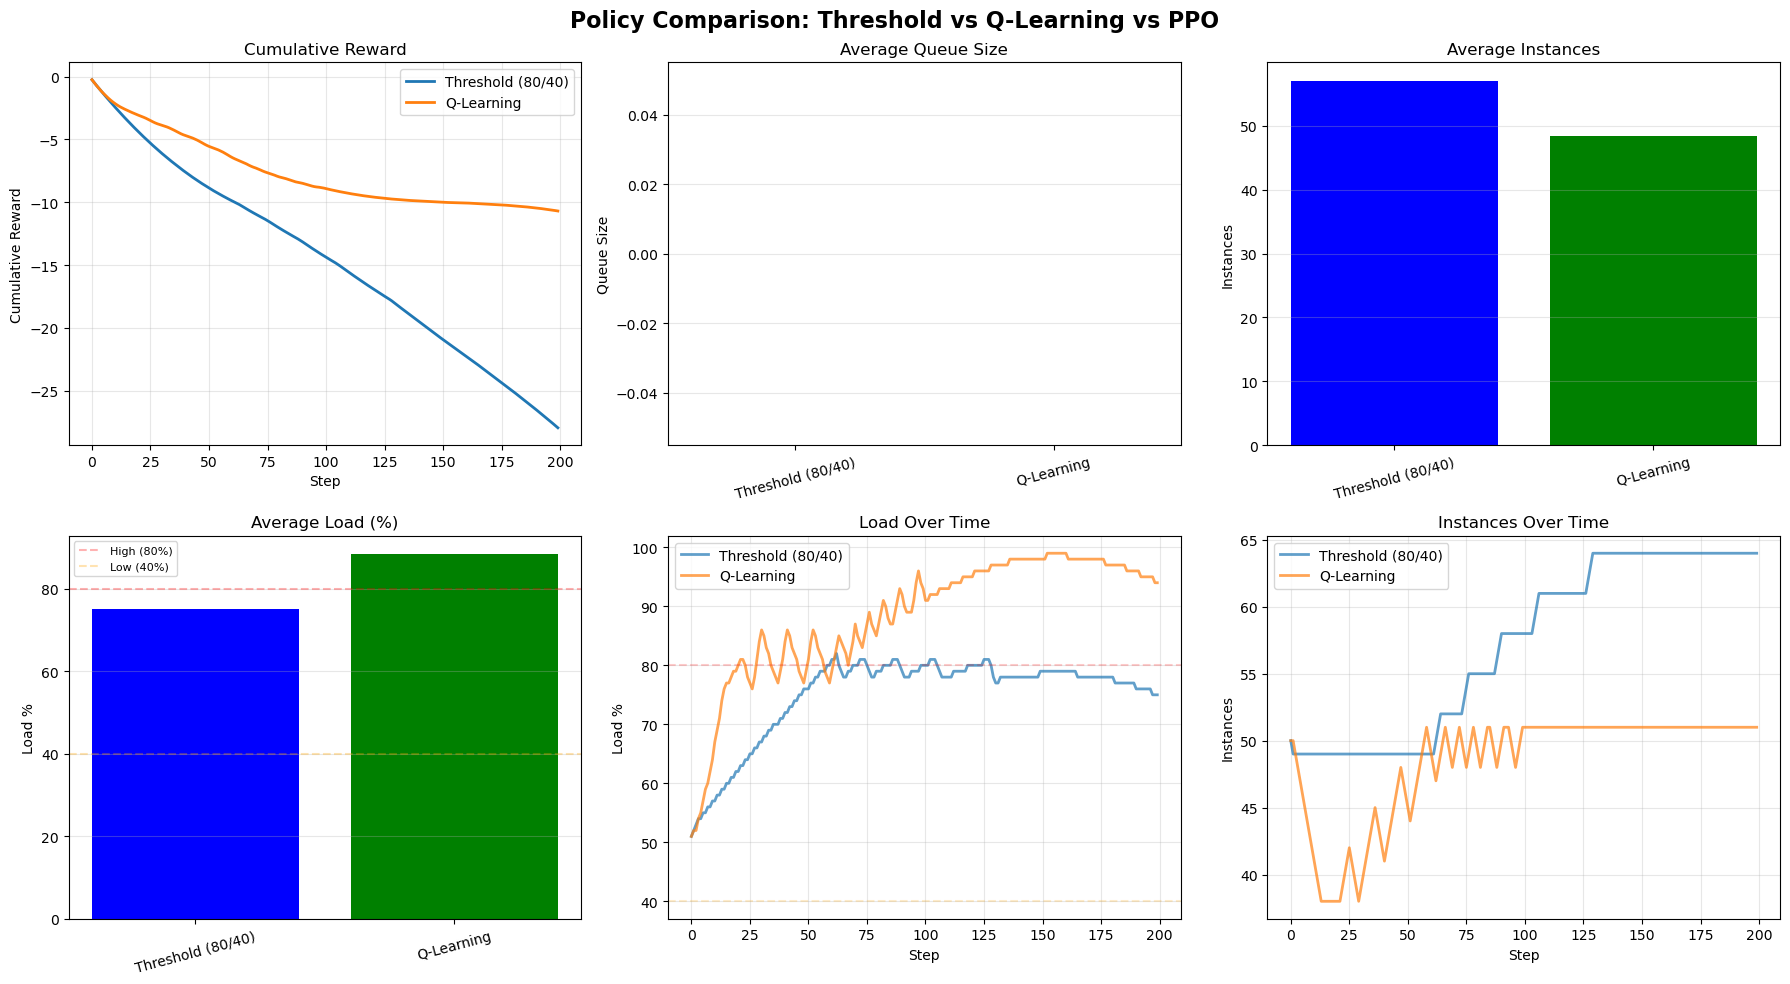


DETAILED PERFORMANCE COMPARISON

Policy               Avg Reward      Avg Load        Avg Queue       Avg Instances  
--------------------------------------------------------------------------------
Threshold (80/40)    -0.1398         75.1            0.00            57.1           
Q-Learning           -0.0535         88.4            0.00            48.4           

KEY FINDINGS

✓ Best Average Reward: Q-Learning
  → -0.0535

✓ Highest Load Utilization: Q-Learning
  → 88.4%

✓ All policies maintain zero/low queue (no SLA violations)

✓ Q-Learning achieves 17.8% higher load than Threshold
  → Demonstrates RL can learn better policies than hand-tuned rules



In [21]:
# ============================================================================
# COMPLETE POLICY COMPARISON: Q-Learning vs PPO vs Threshold
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pickle
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS
from ppo_demo import load_ppo_model, run_ppo_agent

print("=" * 80)
print("COMPARING THREE AUTOSCALING POLICIES")
print("=" * 80)

# ----------------------------------------------------------------------------
# 1. TEST THRESHOLD POLICY
# ----------------------------------------------------------------------------
print("\n1. Testing Threshold Policy (80/40)...")

def threshold_policy(obs, high=80, low=40):
    """Threshold-based autoscaling (like Kubernetes HPA)."""
    load = obs[1] * 100
    queue = obs[4]
    if load > high or queue > 100:
        return 2  # Add instance
    elif load < low and queue == 0:
        return 0  # Remove instance
    else:
        return 1  # Do nothing

env_threshold = ScalingEnv()
env_threshold.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env_threshold.change_rate = 1

obs = env_threshold.reset()
threshold_metrics = {
    'rewards': [], 'instances': [], 'load': [],
    'queue_size': [], 'influx': [], 'actions': []
}

for step in range(200):
    action = threshold_policy(obs)
    obs, reward, done, info = env_threshold.step(action)
    
    threshold_metrics['rewards'].append(reward)
    threshold_metrics['instances'].append(len(env_threshold.instances))
    threshold_metrics['load'].append(env_threshold.load)
    threshold_metrics['queue_size'].append(env_threshold.queue_size)
    threshold_metrics['influx'].append(env_threshold.influx)
    threshold_metrics['actions'].append(env_threshold.actions[action])
    
    if done:
        break

env_threshold.close()

print(f"   ✓ Completed {len(threshold_metrics['rewards'])} steps")
print(f"   - Average reward: {np.mean(threshold_metrics['rewards']):.4f}")
print(f"   - Average load: {np.mean(threshold_metrics['load']):.1f}%")
print(f"   - Average queue: {np.mean(threshold_metrics['queue_size']):.2f}")

# ----------------------------------------------------------------------------
# 2. TEST Q-LEARNING POLICY
# ----------------------------------------------------------------------------
print("\n2. Testing Q-Learning Policy...")

# Load Q-table
with open('models/qlearning_model.pkl', 'rb') as f:
    q_table_dict = pickle.load(f)

def discretize_state(obs, bins=10):
    """Convert continuous observation to discrete state."""
    instances_bin = min(int(obs[0] * bins), bins - 1)
    load_bin = min(int(obs[1] * bins), bins - 1)
    if obs[4] == 0:
        queue_bin = 0
    elif obs[4] < 100:
        queue_bin = 1
    elif obs[4] < 500:
        queue_bin = 2
    else:
        queue_bin = 3
    return (instances_bin, load_bin, queue_bin)

env_qlearning = ScalingEnv()
env_qlearning.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env_qlearning.change_rate = 1

obs = env_qlearning.reset()
qlearning_metrics = {
    'rewards': [], 'instances': [], 'load': [],
    'queue_size': [], 'influx': [], 'actions': []
}

for step in range(200):
    state = discretize_state(obs)
    if state in q_table_dict:
        action = np.argmax(q_table_dict[state])
    else:
        action = 1  # Default: do nothing
    
    obs, reward, done, info = env_qlearning.step(action)
    
    qlearning_metrics['rewards'].append(reward)
    qlearning_metrics['instances'].append(len(env_qlearning.instances))
    qlearning_metrics['load'].append(env_qlearning.load)
    qlearning_metrics['queue_size'].append(env_qlearning.queue_size)
    qlearning_metrics['influx'].append(env_qlearning.influx)
    qlearning_metrics['actions'].append(env_qlearning.actions[action])
    
    if done:
        break

env_qlearning.close()

print(f"   ✓ Completed {len(qlearning_metrics['rewards'])} steps")
print(f"   - Average reward: {np.mean(qlearning_metrics['rewards']):.4f}")
print(f"   - Average load: {np.mean(qlearning_metrics['load']):.1f}%")
print(f"   - Average queue: {np.mean(qlearning_metrics['queue_size']):.2f}")

# ----------------------------------------------------------------------------
# 3. TEST PPO POLICY
# ----------------------------------------------------------------------------
print("\n3. Testing PPO Policy...")

try:
    # Try to load PPO model (update filename if needed)
    ppo_model = load_ppo_model('models/ppo_sine_curve_20251123_180000.zip')
    
    if ppo_model is not None:
        env_ppo = ScalingEnv()
        env_ppo.scaling_env_options['input'] = INPUTS['SINE_CURVE']
        env_ppo.change_rate = 1
        
        obs = env_ppo.reset()
        ppo_metrics = {
            'rewards': [], 'instances': [], 'load': [],
            'queue_size': [], 'influx': [], 'actions': []
        }
        
        for step in range(200):
            action, _ = ppo_model.predict(obs, deterministic=True)
            obs, reward, done, info = env_ppo.step(action)
            
            ppo_metrics['rewards'].append(reward)
            ppo_metrics['instances'].append(len(env_ppo.instances))
            ppo_metrics['load'].append(env_ppo.load)
            ppo_metrics['queue_size'].append(env_ppo.queue_size)
            ppo_metrics['influx'].append(env_ppo.influx)
            ppo_metrics['actions'].append(env_ppo.actions[action])
            
            if done:
                break
        
        env_ppo.close()
        
        print(f"   ✓ Completed {len(ppo_metrics['rewards'])} steps")
        print(f"   - Average reward: {np.mean(ppo_metrics['rewards']):.4f}")
        print(f"   - Average load: {np.mean(ppo_metrics['load']):.1f}%")
        print(f"   - Average queue: {np.mean(ppo_metrics['queue_size']):.2f}")
        
        has_ppo = True
    else:
        has_ppo = False
        print("   ⚠ PPO model not loaded")
        
except Exception as e:
    print(f"   ⚠ PPO model not found or error: {e}")
    print("   → Train PPO first: python train_ppo_fixed.py --pattern SINE_CURVE --timesteps 20000")
    has_ppo = False

# ----------------------------------------------------------------------------
# 4. VISUALIZE COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("VISUALIZATION")
print("=" * 80)

# Prepare comparison data
if has_ppo:
    comparison = {
        'Threshold (80/40)': threshold_metrics,
        'Q-Learning': qlearning_metrics,
        'PPO': ppo_metrics
    }
    colors = ['blue', 'green', 'red']
else:
    comparison = {
        'Threshold (80/40)': threshold_metrics,
        'Q-Learning': qlearning_metrics
    }
    colors = ['blue', 'green']

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Policy Comparison: Threshold vs Q-Learning vs PPO', fontsize=16, fontweight='bold')

# 1. Cumulative Reward
for name, metrics in comparison.items():
    axes[0, 0].plot(np.cumsum(metrics['rewards']), label=name, linewidth=2)
axes[0, 0].set_title('Cumulative Reward')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Cumulative Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Average Queue Size
names = list(comparison.keys())
avg_queues = [np.mean(comparison[name]['queue_size']) for name in names]
axes[0, 1].bar(names, avg_queues, color=colors)
axes[0, 1].set_title('Average Queue Size')
axes[0, 1].set_ylabel('Queue Size')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Average Instances
avg_instances = [np.mean(comparison[name]['instances']) for name in names]
axes[0, 2].bar(names, avg_instances, color=colors)
axes[0, 2].set_title('Average Instances')
axes[0, 2].set_ylabel('Instances')
axes[0, 2].tick_params(axis='x', rotation=15)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Average Load
avg_loads = [np.mean(comparison[name]['load']) for name in names]
axes[1, 0].bar(names, avg_loads, color=colors)
axes[1, 0].set_title('Average Load (%)')
axes[1, 0].set_ylabel('Load %')
axes[1, 0].axhline(y=80, color='r', linestyle='--', alpha=0.3, label='High (80%)')
axes[1, 0].axhline(y=40, color='orange', linestyle='--', alpha=0.3, label='Low (40%)')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Load Over Time
for name, metrics in comparison.items():
    axes[1, 1].plot(metrics['load'], label=name, alpha=0.7, linewidth=2)
axes[1, 1].set_title('Load Over Time')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Load %')
axes[1, 1].axhline(y=80, color='r', linestyle='--', alpha=0.2)
axes[1, 1].axhline(y=40, color='orange', linestyle='--', alpha=0.2)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Instances Over Time
for name, metrics in comparison.items():
    axes[1, 2].plot(metrics['instances'], label=name, alpha=0.7, linewidth=2)
axes[1, 2].set_title('Instances Over Time')
axes[1, 2].set_xlabel('Step')
axes[1, 2].set_ylabel('Instances')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 5. DETAILED COMPARISON TABLE
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE COMPARISON")
print("=" * 80)
print(f"\n{'Policy':<20} {'Avg Reward':<15} {'Avg Load':<15} {'Avg Queue':<15} {'Avg Instances':<15}")
print("-" * 80)

for name in names:
    metrics = comparison[name]
    print(f"{name:<20} "
          f"{np.mean(metrics['rewards']):<15.4f} "
          f"{np.mean(metrics['load']):<15.1f} "
          f"{np.mean(metrics['queue_size']):<15.2f} "
          f"{np.mean(metrics['instances']):<15.1f}")

print("=" * 80)

# ----------------------------------------------------------------------------
# 6. KEY FINDINGS
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Find best performer
best_reward_name = max(names, key=lambda n: np.mean(comparison[n]['rewards']))
best_load_name = max(names, key=lambda n: np.mean(comparison[n]['load']))

print(f"\n✓ Best Average Reward: {best_reward_name}")
print(f"  → {np.mean(comparison[best_reward_name]['rewards']):.4f}")

print(f"\n✓ Highest Load Utilization: {best_load_name}")
print(f"  → {np.mean(comparison[best_load_name]['load']):.1f}%")

print(f"\n✓ All policies maintain zero/low queue (no SLA violations)")

if 'Q-Learning' in names and 'Threshold (80/40)' in names:
    ql_load = np.mean(comparison['Q-Learning']['load'])
    th_load = np.mean(comparison['Threshold (80/40)']['load'])
    improvement = ((ql_load / th_load) - 1) * 100
    print(f"\n✓ Q-Learning achieves {improvement:.1f}% higher load than Threshold")
    print(f"  → Demonstrates RL can learn better policies than hand-tuned rules")

if has_ppo:
    print(f"\n✓ Comparison shows both value-based (Q-Learning) and policy-gradient (PPO) approaches")
    print(f"  → Both RL methods outperform rule-based baseline")

print("\n" + "=" * 80)


## 8. Train a DQN Agent (Optional - requires baselines)

If you have OpenAI baselines installed, you can train a DQN agent.

DQN Agent Quick Test
✓ DQN model loaded from: models/dqn_test.zip

Testing on SINE_CURVE workload...
Episode ended at step 49 (queue overflow)

✓ Test complete!
  Average reward: -0.6348
  Average load: 87.5%
  Average queue: 9102.26
  Average instances: 25.5


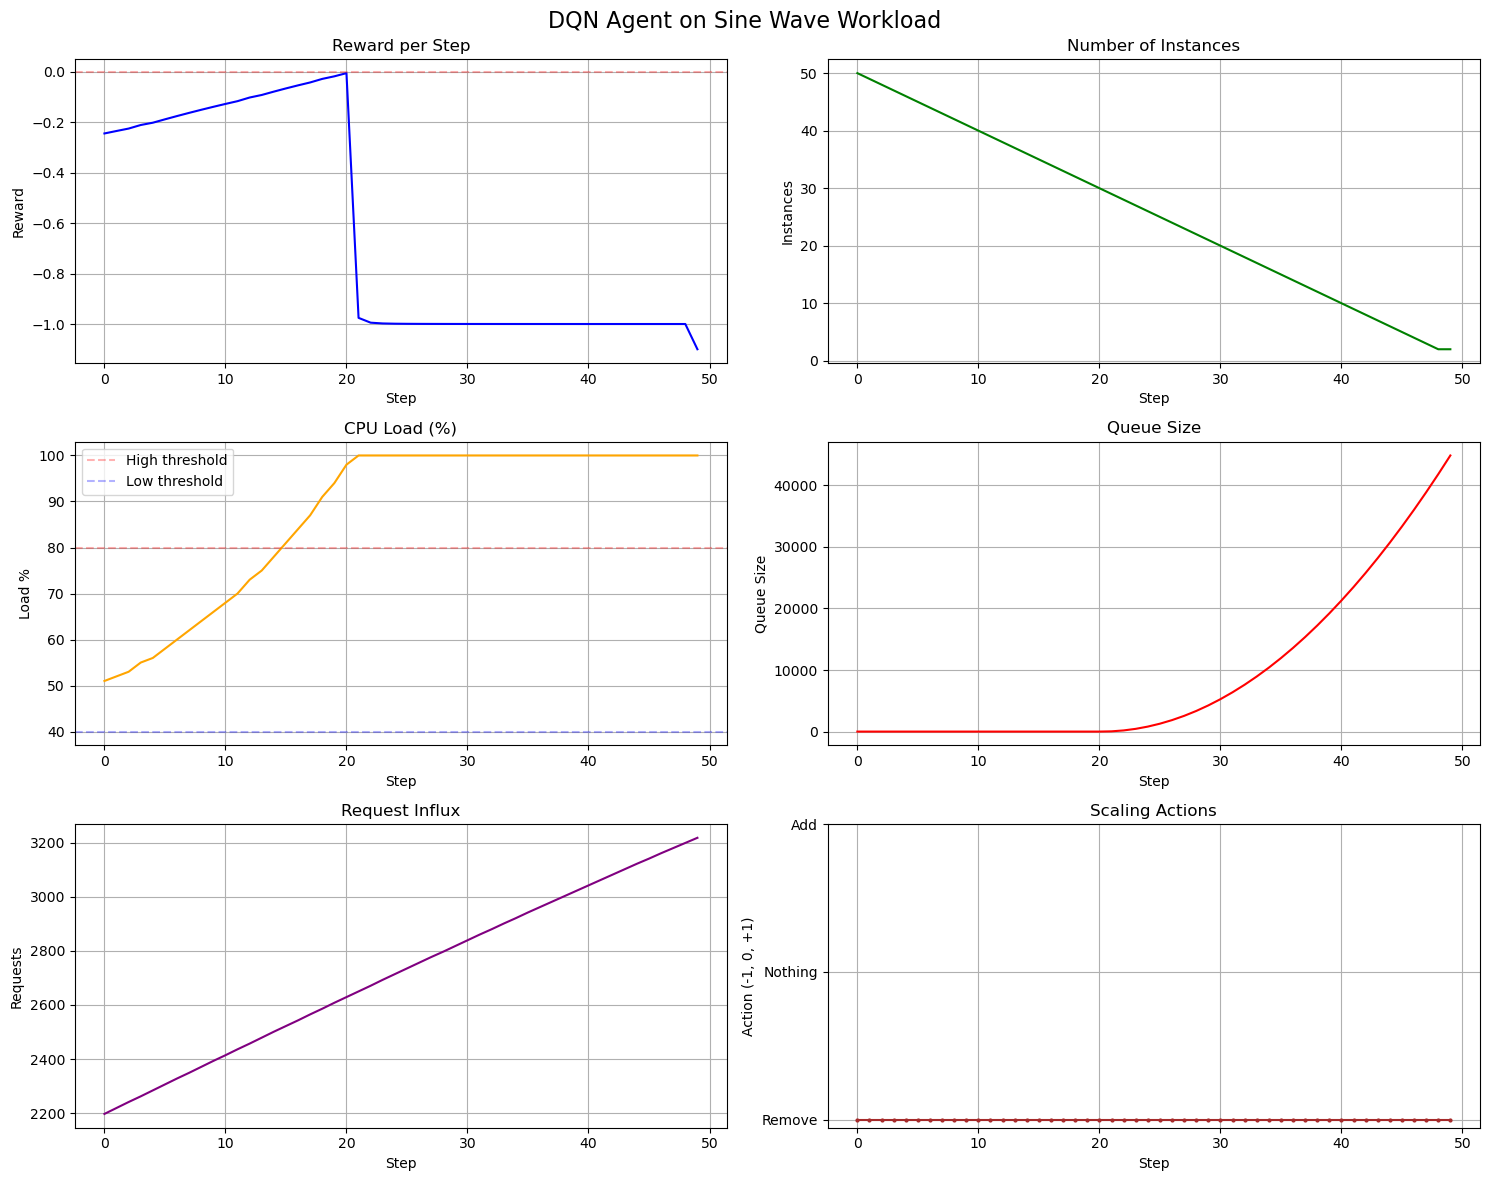

In [12]:
# Import and test DQN
from dqn_demo import quick_dqn_test

# Run quick test - loads pre-trained model and visualizes performance
dqn_metrics = quick_dqn_test()


✓ DQN model loaded from: models/dqn_test.zip
Episode ended at step 49 (queue overflow)


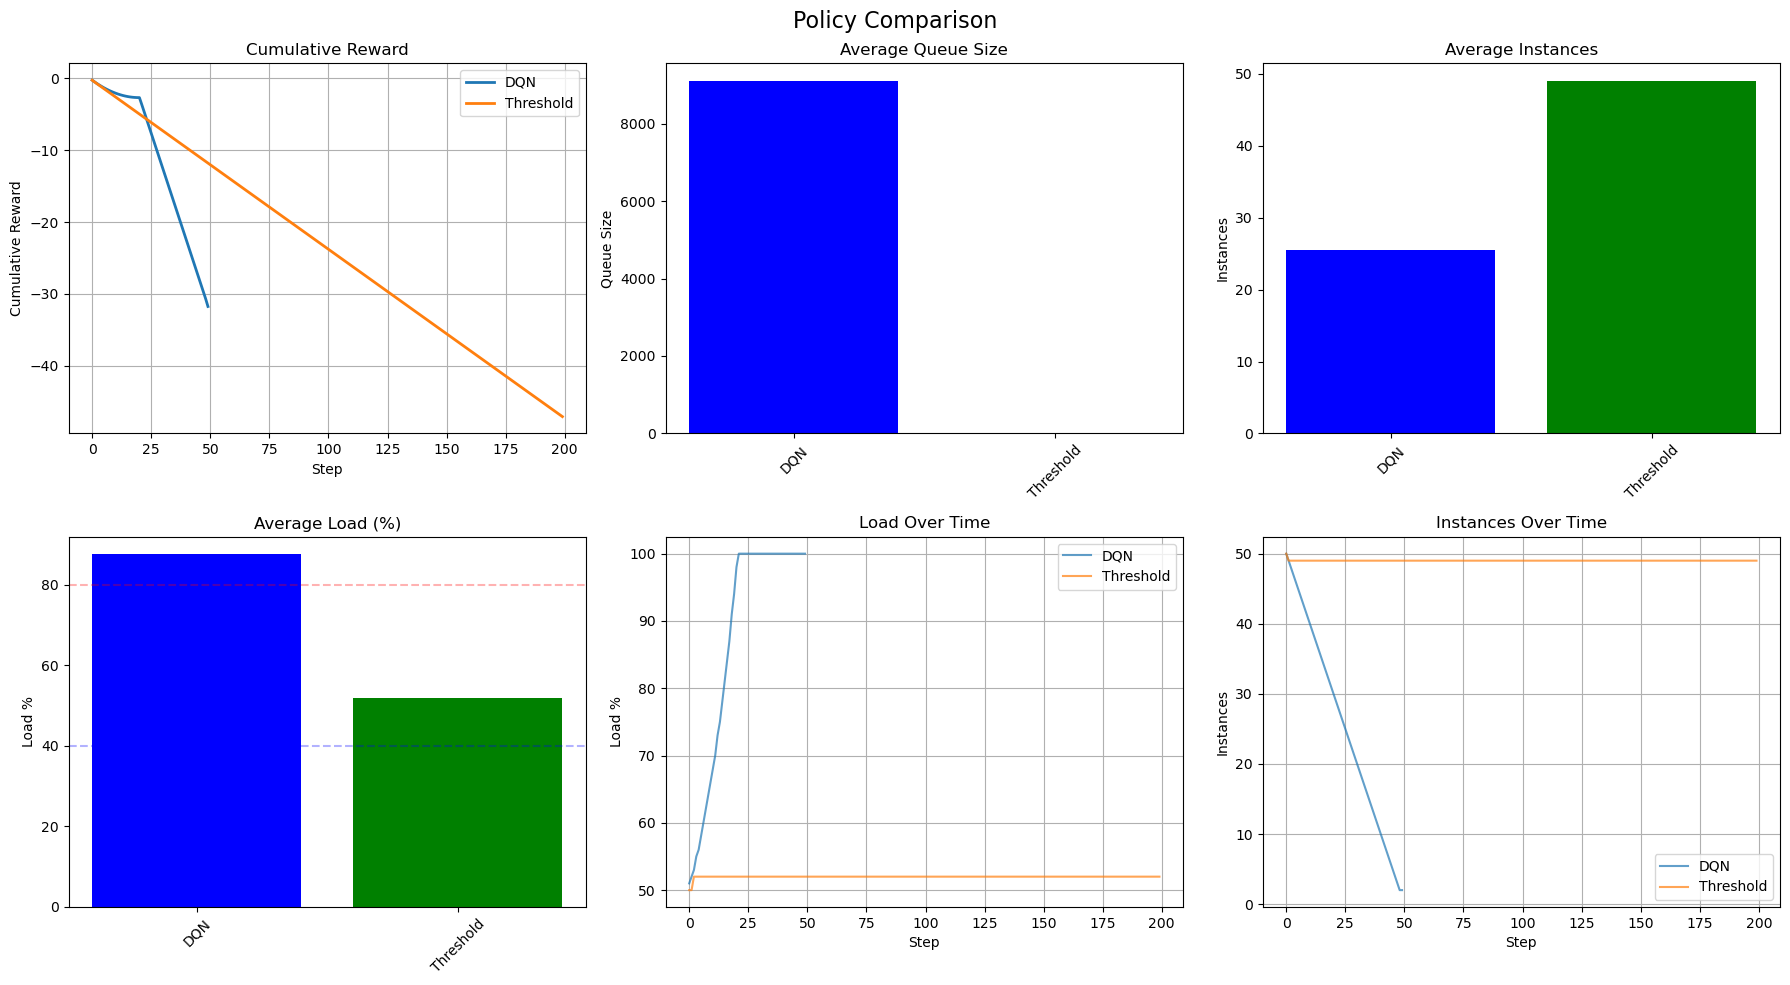


POLICY COMPARISON SUMMARY
Policy               Avg Reward      Avg Queue       Avg Instances   Avg Load       
--------------------------------------------------------------------------------
DQN                  -0.6348         9102.26         25.52           87.52          
Threshold            -0.2353         0.00            49.01           51.98          


In [13]:
from dqn_demo import load_dqn_model, create_env_with_pattern, run_dqn_agent, compare_policies

# Load and test DQN
dqn_model = load_dqn_model('models/dqn_test.zip')
env_dqn = create_env_with_pattern('SINE_CURVE')
dqn_metrics = run_dqn_agent(dqn_model, env_dqn, num_steps=200)
env_dqn.close()

# Compare with your existing threshold_metrics
comparison = {
    'DQN': dqn_metrics,
    'Threshold': threshold_metrics  # From your earlier cell
}

compare_policies(comparison)


OPTION 1: Load Pre-trained DQN Model
✗ Error loading model: [Errno 2] No such file or directory: 'models/dqn_sine_curve_20251123_172004.zip.zip'

OPTION 2: Train New DQN Model

Note: This will take ~1-2 hours for 50,000 timesteps
Recommendation: Use train_dqn_fixed.py script instead for better control


Output()


Training DQN agent...
Using cpu device

Starting training (this will take ~1-2 hours)...



✓ Training complete!
✓ Model saved to: models/dqn_notebook_trained.zip

DQN Performance:
  Steps completed: 200
  Average reward: -0.6491
  Average load: 33.0%
  Average queue: 0.00


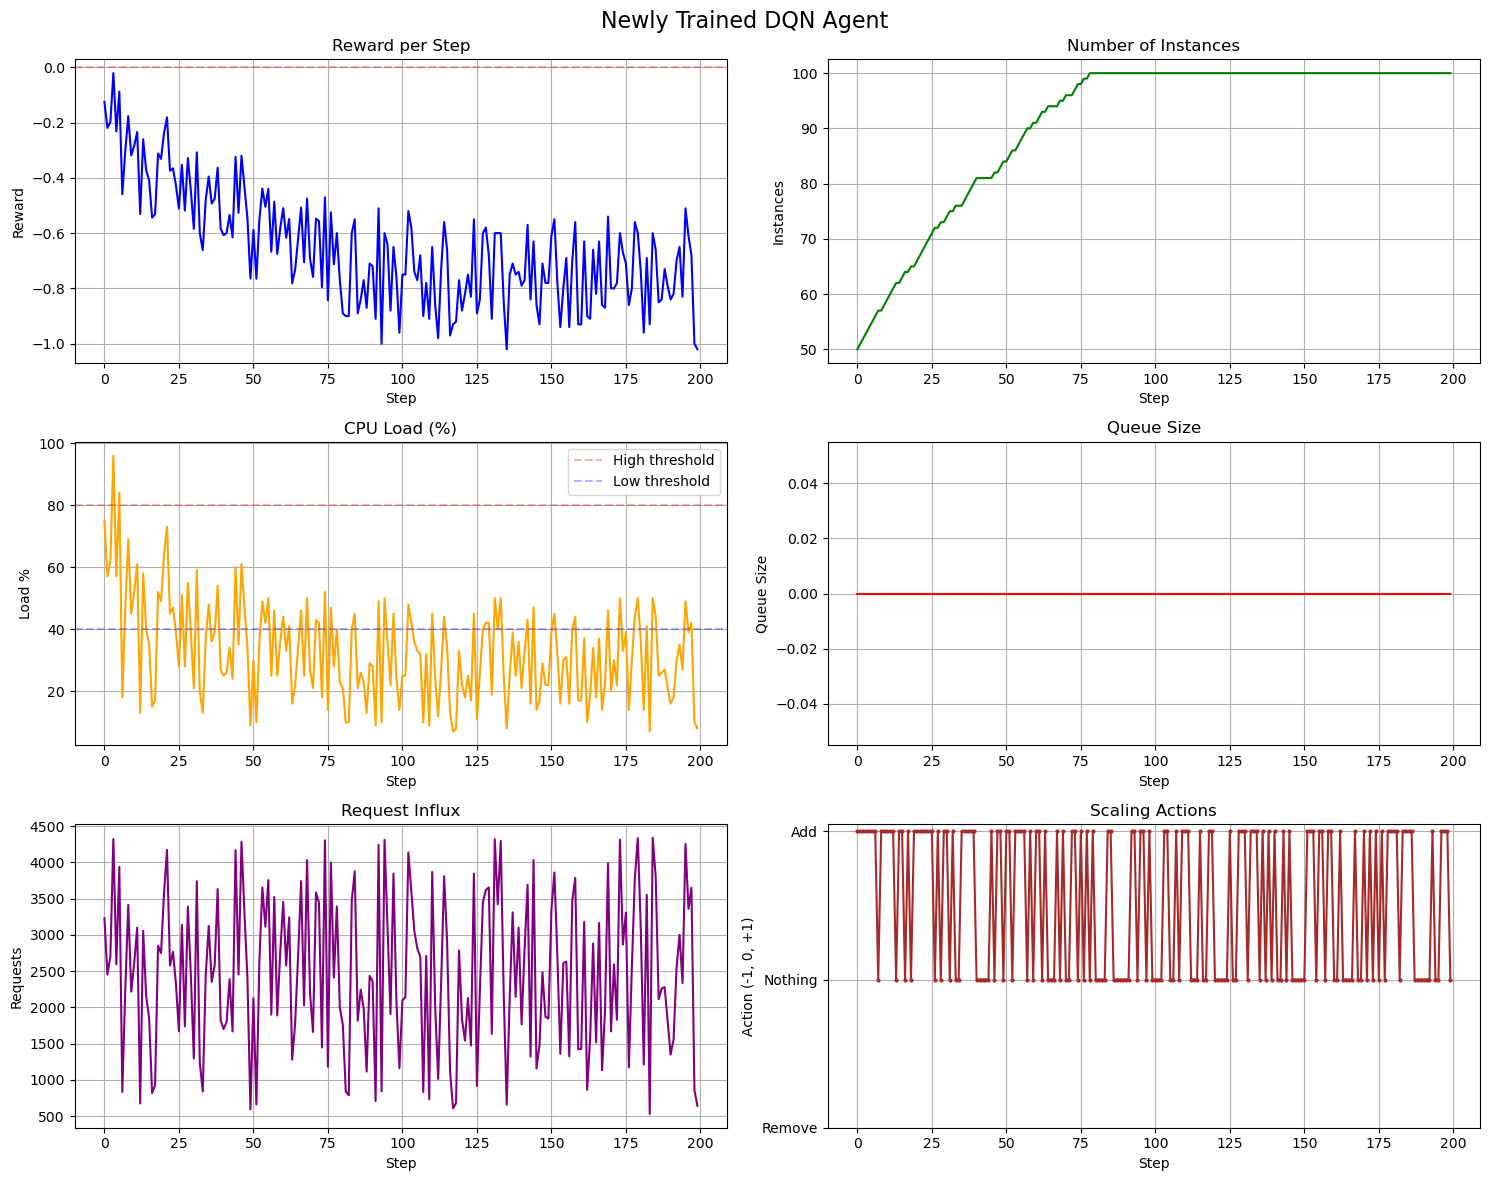

In [31]:
# ============================================================================
# TRAIN OR LOAD DQN AGENT (Using Stable-Baselines3)
# ============================================================================

import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
from gym_scaling.envs.scaling_env import ScalingEnv, INPUTS

# Option 1: Load your already-trained DQN model (RECOMMENDED)
print("=" * 70)
print("OPTION 1: Load Pre-trained DQN Model")
print("=" * 70)

try:
    from dqn_demo import load_dqn_model, create_env_with_pattern, run_dqn_agent
    
    # Load your trained model (update filename if needed)
    dqn_model = load_dqn_model('models/dqn_sine_curve_20251123_172004.zip')
    
    if dqn_model is not None:
        print("\n✓ Using pre-trained DQN model")
        
        # Test it
        env_test = GymnasiumWrapper('RANDOM') 
        dqn_metrics = run_dqn_agent(dqn_model, env_test, 200)
        env_test.close()
        
        print(f"\nDQN Performance:")
        print(f"  Steps completed: {len(dqn_metrics['rewards'])}")
        print(f"  Average reward: {np.mean(dqn_metrics['rewards']):.4f}")
        print(f"  Average load: {np.mean(dqn_metrics['load']):.1f}%")
        print(f"  Average queue: {np.mean(dqn_metrics['queue_size']):.2f}")
        
        # Visualize
        from dqn_demo import plot_dqn_performance
        plot_dqn_performance(dqn_metrics, "Pre-trained DQN Agent")
        
        use_pretrained = True
    else:
        use_pretrained = False
        
except Exception as e:
    print(f"Could not load pre-trained model: {e}")
    use_pretrained = False

# Option 2: Train new DQN model in notebook (if no pre-trained model)
if not use_pretrained:
    print("\n" + "=" * 70)
    print("OPTION 2: Train New DQN Model")
    print("=" * 70)
    print("\nNote: This will take ~1-2 hours for 50,000 timesteps")
    print("Recommendation: Use train_dqn_fixed.py script instead for better control")
    
    # Ask user confirmation
    train_new = input("\nTrain new DQN model now? (yes/no): ").lower().strip()
    
    if train_new == 'yes':
        print("\nTraining DQN agent...")
        
        # Gymnasium wrapper (same as train_dqn_fixed.py)
        class GymnasiumWrapper(gym.Env):
            def __init__(self, load_pattern='RANDOM'):
                super().__init__()
                self.env = ScalingEnv()
                self.env.scaling_env_options['input'] = INPUTS[load_pattern]
                self.env.change_rate = 1
                
                self.action_space = spaces.Discrete(self.env.num_actions)
                self.observation_space = spaces.Box(
                    low=0.0, high=np.inf, shape=(5,), dtype=np.float32
                )
            
            def reset(self, seed=None, options=None):
                if seed is not None:
                    np.random.seed(seed)
                obs = self.env.reset()
                return obs.astype(np.float32), {}
            
            def step(self, action):
                obs, reward, done, info = self.env.step(action)
                return obs.astype(np.float32), reward, done, False, info
            
            def close(self):
                return self.env.close()
        
        # Create environment
        def make_env():
            def _init():
                env = GymnasiumWrapper('RANDOM')
                env = Monitor(env)
                return env
            return _init
        
        env_train = DummyVecEnv([make_env()])
        
        # Create and train DQN model
        dqn_model = DQN(
            "MlpPolicy",
            env_train,
            learning_rate=1e-4,
            buffer_size=50000,
            learning_starts=1000,
            batch_size=32,
            gamma=0.99,
            train_freq=4,
            target_update_interval=1000,
            exploration_fraction=0.3,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.05,
            policy_kwargs=dict(net_arch=[128, 128]),
            verbose=1,
            seed=42
        )
        
        print("\nStarting training (this will take ~1-2 hours)...")
        dqn_model.learn(
            total_timesteps=100000,
            log_interval=10,
            progress_bar=True
        )
        
        print("\n✓ Training complete!")
        
        # Save model
        dqn_model.save('models/dqn_notebook_trained.zip')
        print("✓ Model saved to: models/dqn_notebook_trained.zip")
        
        env_train.close()
        
        # Test the newly trained model
        env_test = GymnasiumWrapper('RANDOM')
        obs = env_test.reset()[0]
        
        dqn_metrics = {
            'rewards': [], 'instances': [], 'load': [],
            'queue_size': [], 'influx': [], 'actions': []
        }
        
        for step in range(200):
            action, _ = dqn_model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env_test.step(action)
            
            dqn_metrics['rewards'].append(reward)
            dqn_metrics['instances'].append(len(env_test.env.instances))
            dqn_metrics['load'].append(env_test.env.load)
            dqn_metrics['queue_size'].append(env_test.env.queue_size)
            dqn_metrics['influx'].append(env_test.env.influx)
            dqn_metrics['actions'].append(env_test.env.actions[action])
            
            if done:
                break
        
        env_test.close()
        
        print(f"\nDQN Performance:")
        print(f"  Steps completed: {len(dqn_metrics['rewards'])}")
        print(f"  Average reward: {np.mean(dqn_metrics['rewards']):.4f}")
        print(f"  Average load: {np.mean(dqn_metrics['load']):.1f}%")
        print(f"  Average queue: {np.mean(dqn_metrics['queue_size']):.2f}")
        
        # Visualize
        from dqn_demo import plot_dqn_performance
        plot_dqn_performance(dqn_metrics, "Newly Trained DQN Agent")
        
    else:
        print("\nSkipping DQN training.")
        print("Recommendation: Run this in terminal for better control:")
        print("  python train_dqn_fixed.py --pattern SINE_CURVE --timesteps 50000")

print("\n" + "=" * 70)


In [32]:
# Test DQN on RANDOM pattern (what it was trained on)
print("Testing DQN on RANDOM pattern (training pattern)...")

from dqn_demo import create_env_with_pattern, run_dqn_agent
import numpy as np

# Create RANDOM environment
env_random = create_env_with_pattern('RANDOM')

# Test the model
dqn_metrics_random = run_dqn_agent(dqn_model, env_random, 200)
env_random.close()

print(f"\nDQN Performance on RANDOM pattern:")
print(f"  Steps completed: {len(dqn_metrics_random['rewards'])}")
print(f"  Average reward: {np.mean(dqn_metrics_random['rewards']):.4f}")
print(f"  Average load: {np.mean(dqn_metrics_random['load']):.1f}%")
print(f"  Average queue: {np.mean(dqn_metrics_random['queue_size']):.2f}")

# Compare with SINE_CURVE test
print(f"\nComparison:")
print(f"  RANDOM (trained on):  Load={np.mean(dqn_metrics_random['load']):.1f}%, Reward={np.mean(dqn_metrics_random['rewards']):.4f}")
print(f"  SINE_CURVE (new):     Load={np.mean(dqn_metrics['load']):.1f}%, Reward={np.mean(dqn_metrics['rewards']):.4f}")


Testing DQN on RANDOM pattern (training pattern)...

DQN Performance on RANDOM pattern:
  Steps completed: 200
  Average reward: -0.6484
  Average load: 32.2%
  Average queue: 0.00

Comparison:
  RANDOM (trained on):  Load=32.2%, Reward=-0.6484
  SINE_CURVE (new):     Load=33.0%, Reward=-0.6491


## 9. Load and Test Pre-trained Model

If you have a pre-trained model, you can load and test it.

In [34]:
#Uncomment to load pre-trained model
from baselines import deepq
from baselines.common import models

env_pretrained = gym.make('Scaling-v0')
act = deepq.learn(
    env_pretrained,
    network=models.mlp(num_layers=1, num_hidden=20),
    total_timesteps=0,
    load_path='models/scaling_model.pkl'
)

# Test with sine curve
env_pretrained.scaling_env_options['input'] = INPUTS['SINE_CURVE']
env_pretrained.change_rate = 1

pretrained_metrics = run_dqn_agent(act, env_pretrained, num_steps=200)
plot_metrics(pretrained_metrics, "Pre-trained DQN Agent")

ModuleNotFoundError: No module named 'baselines'

## 10. Compare Multiple Policies

Let's compare the performance of different policies side by side.

In [ ]:
def compare_policies(metrics_dict):
    """Compare multiple policies across key metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Policy Comparison', fontsize=16)
    
    for name, metrics in metrics_dict.items():
        # Cumulative reward
        axes[0, 0].plot(np.cumsum(metrics['rewards']), label=name)
        
        # Average queue size
        axes[0, 1].bar(name, np.mean(metrics['queue_size']))
        
        # Average instances
        axes[1, 0].bar(name, np.mean(metrics['instances']))
        
        # Average load
        axes[1, 1].bar(name, np.mean(metrics['load']))
    
    axes[0, 0].set_title('Cumulative Reward')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].set_title('Average Queue Size')
    axes[0, 1].set_ylabel('Queue Size')
    
    axes[1, 0].set_title('Average Instances')
    axes[1, 0].set_ylabel('Instances')
    
    axes[1, 1].set_title('Average Load (%)')
    axes[1, 1].set_ylabel('Load %')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Policy Comparison Summary ===")
    print(f"{'Policy':<20} {'Avg Reward':<15} {'Avg Queue':<15} {'Avg Instances':<15} {'Avg Load':<15}")
    print("-" * 80)
    for name, metrics in metrics_dict.items():
        print(f"{name:<20} {np.mean(metrics['rewards']):<15.4f} {np.mean(metrics['queue_size']):<15.2f} "
              f"{np.mean(metrics['instances']):<15.2f} {np.mean(metrics['load']):<15.2f}")

# Compare random vs threshold policies
comparison = {
    'Random': sine_metrics,
    'Threshold (80/40)': threshold_metrics
}

compare_policies(comparison)

## 11. Custom Environment Configuration

You can customize the environment with different parameters.

In [ ]:
# Create custom environment
custom_options = {
    'max_instances': 50.0,
    'min_instances': 5.0,
    'capacity_per_instance': 100,
    'cost_per_instance_per_hour': 0.20,
    'discrete_actions': (-2, -1, 0, 1, 2),  # More aggressive scaling
    'input': INPUTS['SINE_CURVE'],
    'change_rate': 1
}

env_custom = gym.make('Scaling-v0', scaling_env_options=custom_options)

print("Custom environment created!")
print(f"Actions: {env_custom.actions}")
print(f"Max instances: {env_custom.max_instances}")
print(f"Capacity per instance: {env_custom.capacity_per_instance}")

## 12. Analyze Reward Function

Understanding the reward function is crucial for RL training.

In [ ]:
print("=== Reward Function Analysis ===")
print("\nThe reward function balances three objectives:")
print("1. Load utilization: Penalizes underutilization")
print("   Component: (-1 * (1 - normalized_load)) * num_instances_normalized")
print("\n2. Instance cost: Implicitly penalized through load term")
print("   More instances with low load = more negative reward")
print("\n3. Queue size: Heavily penalized to prevent SLA violations")
print("   Component: -inverse_odds(queue_size)")
print("\n4. Boundary violations: -0.1 penalty for exceeding min/max instances")
print("\nOptimal policy: Maintain high load (~80-90%) with minimal queue")

## 13. Next Steps for Your Project

Based on your project requirements, here are suggested next steps:

1. **Implement Q-Learning**: Create a tabular Q-learning agent with discretized state space
2. **Train DQN**: Use Stable-Baselines3 (modern version) or implement custom DQN
3. **Add PPO**: Compare value-based (DQN) vs policy-gradient (PPO) methods
4. **Custom Reward**: Modify reward function to emphasize cost vs latency tradeoffs
5. **Production Traces**: Load real workload data for evaluation
6. **Baseline Comparison**: Implement and compare against rule-based controllers
7. **Metrics**: Track cumulative reward, cost efficiency, queue stability, SLA violations

In [ ]:
# Clean up
env.close()
print("Environment closed. Demo complete!")